# Clustering of all data

Read in all necessary packages:

In [30]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas.io.parsers import read_csv
import scanpy as sc
import numpy as np
from functools import reduce
from anndata import AnnData, read_h5ad
import collections
import scipy
import math
from matplotlib.colors import LinearSegmentedColormap
import random
from sklearn.mixture import GaussianMixture
from scipy.stats import poisson

import scipy
import tqdm
from statsmodels.stats.multitest import multipletests
import matplotlib.patches as mpatches



In [2]:
# Import DESeq2
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

In [3]:
import decoupler as dc

In [4]:
sc.set_figure_params(dpi = 80)
sns.set_style("white")
sns.set_context("talk")
sns.set_style("ticks")

In [5]:
dc.__version__

'1.6.0'

In [6]:
import pydeseq2
pydeseq2.__version__

'0.4.4'

# Load the dataset

### load adata file and define groups for differential expression as 'diffx'

In [9]:
pathToData = '/Users/m.blotenburg/Documents/Projects/preculture_manuscript/processed_files/reanalyse/'
adata_file = pathToData + '20230124_adata_dataset_ESC_all.h5ad'  # the file that will store the analysis results
adata = sc.read(adata_file)

In [10]:
df = pd.read_pickle(pathToData + '/20220217_all_mESCs.pickle.gz')
df.head(2)

e1_1.m-ESC_con1  e1_10.m-ESC_con1  e1_100.m-ESC_con1  \
ENSMUSG00000104017_1              0.0               0.0                0.0   
ENSMUSG00000033845_1              2.0               6.0                0.0   

                      e1_101.m-ESC_con1  e1_102.m-ESC_con1  e1_103.m-ESC_con1  \
ENSMUSG00000104017_1                0.0                0.0                0.0   
ENSMUSG00000033845_1                1.0                2.0                1.0   

                      e1_104.m-ESC_con1  e1_105.m-ESC_con1  e1_106.m-ESC_con1  \
ENSMUSG00000104017_1                0.0                0.0                0.0   
ENSMUSG00000033845_1                6.0                1.0                1.0   

                      e1_107.m-ESC_con1  ...  e12_90.m-ESC_con6  \
ENSMUSG00000104017_1                0.0  ...                0.0   
ENSMUSG00000033845_1                3.0  ...                5.0   

                      e12_91.m-ESC_con6  e12_92.m-ESC_con6  e12_93.m-ESC_con6  \
ENSMUSG00000104017_1                0.0                0.0                0.0   
ENSMUSG00000033845_1                0.0                3.0                2.0   

                      e12_94.m-ESC_con6  e12_95.m-ESC_con6  e12_96.m-ESC_con6  \
ENSMUSG00000104017_1                0.0                0.0                0.0   
ENSMUSG00000033845_1                0.0                2.0                1.0   

                      e12_97.m-ESC_con6  e12_98.m-ESC_con6  e12_99.m-ESC_con6  
ENSMUSG00000104017_1                0.0                0.0                0.0  
ENSMUSG00000033845_1                1.0                0.0                4.0  

[2 rows x 4605 columns]

In [11]:
adata.var['ensembl_chrom'] = adata.var['ensembl'].astype(str) + '_' + adata.var['chromosome'].astype(str)
adata.var.head(2)

ensembl chromosome  n_cells  highly_variable     means  \
Mrpl15  ENSMUSG00000033845          1     3552            False  0.169399   
Lypla1  ENSMUSG00000025903          1     3528            False  0.180757   

        dispersions  dispersions_norm          mean       std  \
Mrpl15    -1.851475          0.262761 -1.184679e-11  0.125496   
Lypla1    -1.924197          0.048336  9.421725e-13  0.129145   

               ensembl_chrom  
Mrpl15  ENSMUSG00000033845_1  
Lypla1  ENSMUSG00000025903_1

In [12]:
adata.shape

(4147, 24136)

In [13]:
df_filtered = df.loc[adata.var['ensembl_chrom'],adata.obs.index].T

In [14]:
df.shape

(33152, 4605)

In [15]:
df_filtered.shape

(4147, 24136)

In [16]:
df_filtered.fillna(0).to_numpy(dtype = 'float32')

array([[2., 3., 2., ..., 0., 0., 0.],
       [6., 5., 0., ..., 0., 0., 0.],
       [1., 2., 2., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [4., 2., 0., ..., 0., 0., 0.]], dtype=float32)

In [17]:
adata.X = df_filtered.fillna(0).to_numpy(dtype = 'float32')

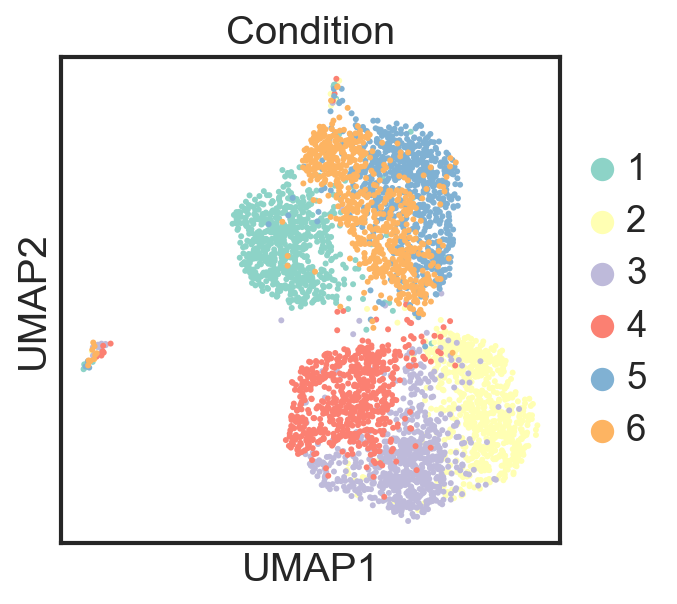

In [31]:
adata.obs['Condition'] = adata.obs['condition']
adata.uns['Condition_colors'] = adata.uns['condition_colors']
adata.obs['Condition'] = [sub.replace('con', '') for sub in adata.obs['Condition']]
adata.obs['Condition'] = adata.obs['Condition'].astype('category')
adata.obs['Condition'] = adata.obs['Condition'].cat.reorder_categories(['1','2','3','4','5','6'])


sc.pl.umap(adata, color = 'Condition')

In [32]:
meta = pd.read_csv(pathToData + '../processed_files/20240425_mESCs_metadata.csv', index_col=0)
meta.head(2)

condition        celltype  leiden plate  n_counts  n_genes  \
e1_1.m-ESC_con1       con1  Shh Signalling       2    e1    7306.0     3604   
e1_10.m-ESC_con1      con1  Shh Signalling       2    e1    9948.0     4020   

                  percent_mito   S_score  G2M_score phase  X_umap-0  X_umap-1  
e1_1.m-ESC_con1       0.068478  0.024311   0.121200   G2M  4.863987  8.068169  
e1_10.m-ESC_con1      0.032744  0.075215   0.022867     S  8.427104  6.595975

In [33]:
adata.obs['celltype'] = meta['celltype']
adata.obs.head(2)

n_counts  n_genes  percent_mito   S_score  G2M_score phase  \
e1_1.m-ESC_con1     7306.0     3604      0.068478  0.024311   0.121200   G2M   
e1_10.m-ESC_con1    9948.0     4020      0.032744  0.075215   0.022867     S   

                  batch        name condition plate leiden Condition  \
e1_1.m-ESC_con1   m-ESC  m-ESC_con1      con1    e1      1         1   
e1_10.m-ESC_con1  m-ESC  m-ESC_con1      con1    e1      4         1   

                        celltype  diffx diffx2  
e1_1.m-ESC_con1   Shh Signalling  ESLIF      1  
e1_10.m-ESC_con1  Shh Signalling  ESLIF      1

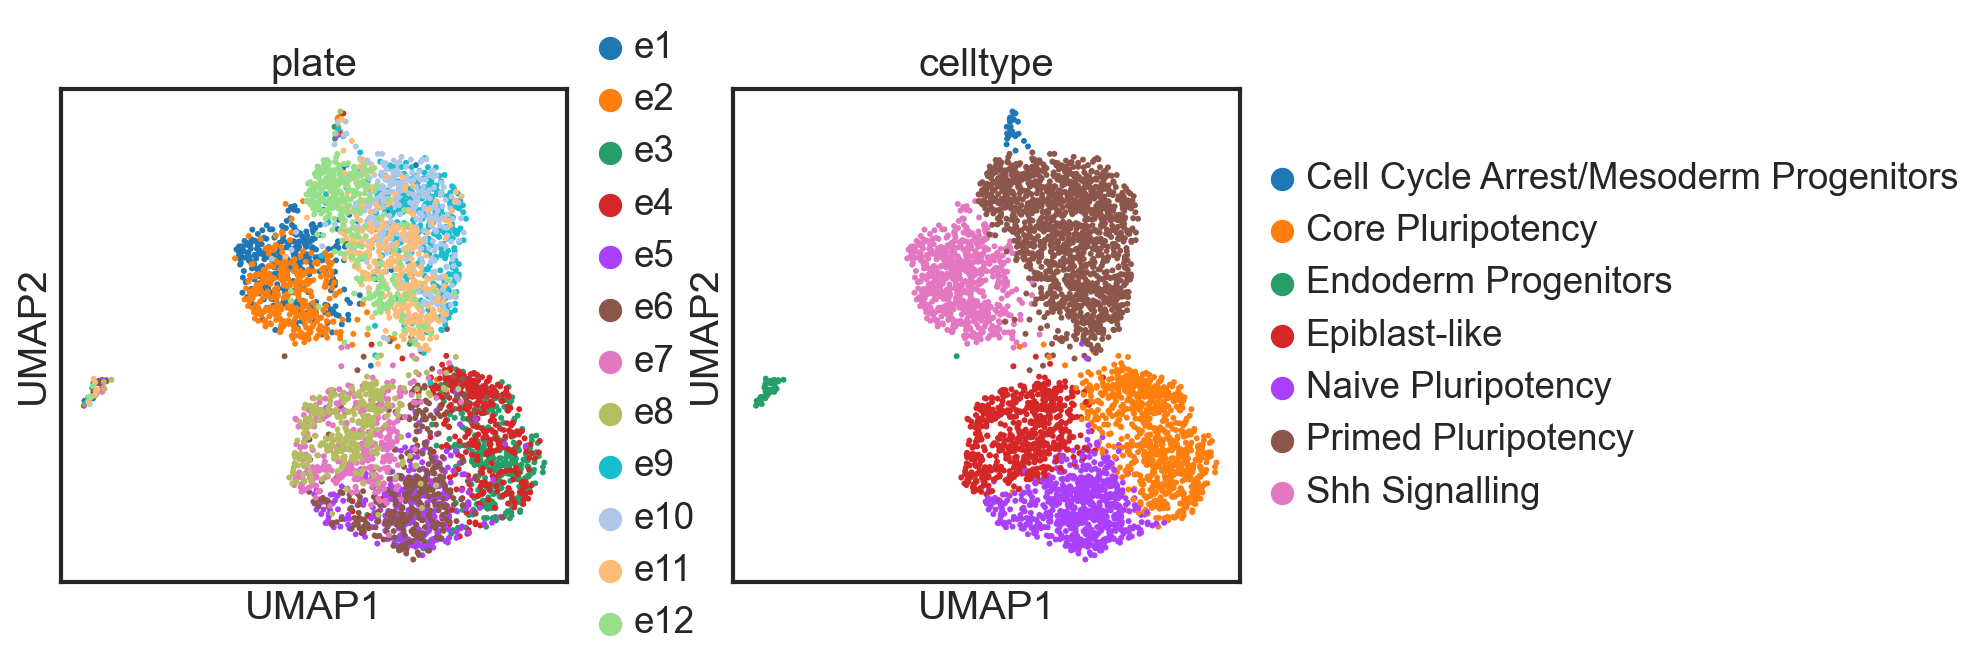

In [34]:
sc.pl.umap(adata, color = ['plate','celltype'])

In [35]:
adata.obs['celltype'].unique()

['Shh Signalling', 'Primed Pluripotency', 'Endoderm Progenitors', 'Cell Cycle Arrest/Mesoderm Progenitors', 'Core Pluripotency', 'Naive Pluripotency', 'Epiblast-like']
Categories (7, object): ['Cell Cycle Arrest/Mesoderm Progenitors', 'Core Pluripotency', 'Endoderm Progenitors', 'Epiblast-like', 'Naive Pluripotency', 'Primed Pluripotency', 'Shh Signalling']

In [36]:
#adata.obs['diffx'] = adata.obs['Condition']

dict_ct = {'1':'ESLIF',
 '2':'2i',
 '3':'2i',
           '4':'2i',
          '5':'ESLIF',
          '6':'ESLIF'}

adata.obs['diffx'] = (
    adata.obs["Condition"]
    .map(lambda x: dict_ct.get(x, x))
    .astype("category")
)

adata.obs['diffx'] = adata.obs['diffx'].astype(str)

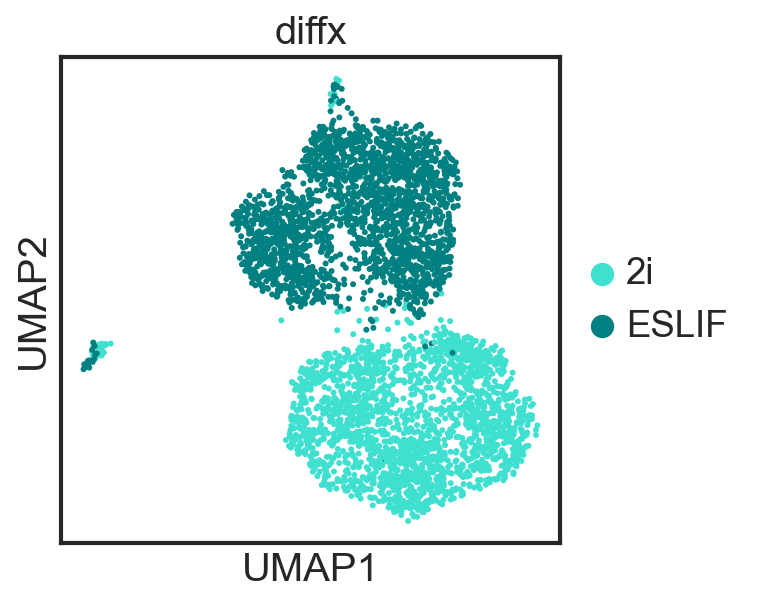

In [37]:
cols = ['turquoise', 'teal','lightgrey']
sc.pl.umap(adata, color = 'diffx', palette = cols )

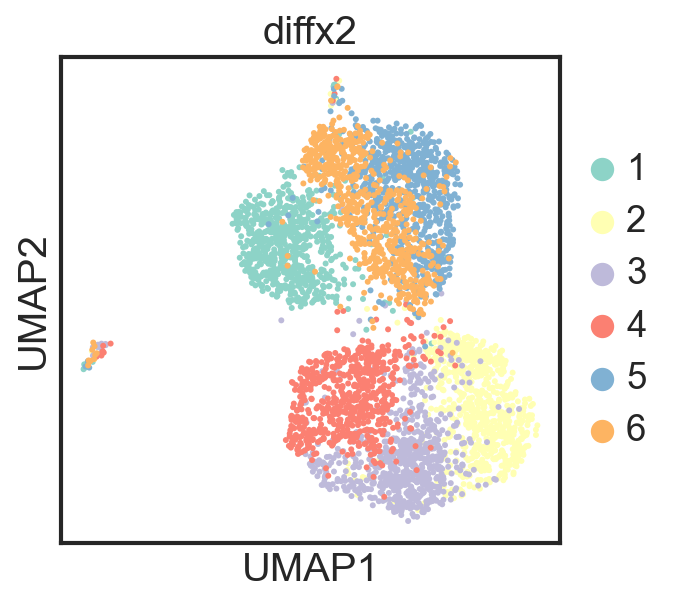

In [38]:
adata.obs['diffx2'] = adata.obs['Condition']
adata.uns['diffx2_colors'] = adata.uns['Condition_colors']
adata.obs['diffx2'] = adata.obs['diffx2'].astype('category')
adata.obs['diffx2'] = adata.obs['diffx2'].cat.reorder_categories(['1','2','3','4','5','6'])
sc.pl.umap(adata, color = 'diffx2')

In [39]:
adata.obs.head(2)

n_counts  n_genes  percent_mito   S_score  G2M_score phase  \
e1_1.m-ESC_con1     7306.0     3604      0.068478  0.024311   0.121200   G2M   
e1_10.m-ESC_con1    9948.0     4020      0.032744  0.075215   0.022867     S   

                  batch        name condition plate leiden Condition  \
e1_1.m-ESC_con1   m-ESC  m-ESC_con1      con1    e1      1         1   
e1_10.m-ESC_con1  m-ESC  m-ESC_con1      con1    e1      4         1   

                        celltype  diffx diffx2  
e1_1.m-ESC_con1   Shh Signalling  ESLIF      1  
e1_10.m-ESC_con1  Shh Signalling  ESLIF      1

In [40]:
sc.settings.verbosity = 2

## start decoupler
make pseudobulks, filter, run pydeseq

In [41]:
import decoupler as dc

Add back raw counts before pseudobulking - first group cells into pseudobulks, then normalise and log-transform counts again

In [42]:
#adata.X = adata.raw.X

### define pseudobulks 

In [43]:
# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata,
    groups_col='diffx',
    sample_col='diffx2',
    mode='mean',
    min_cells=10,
    min_counts=0
)


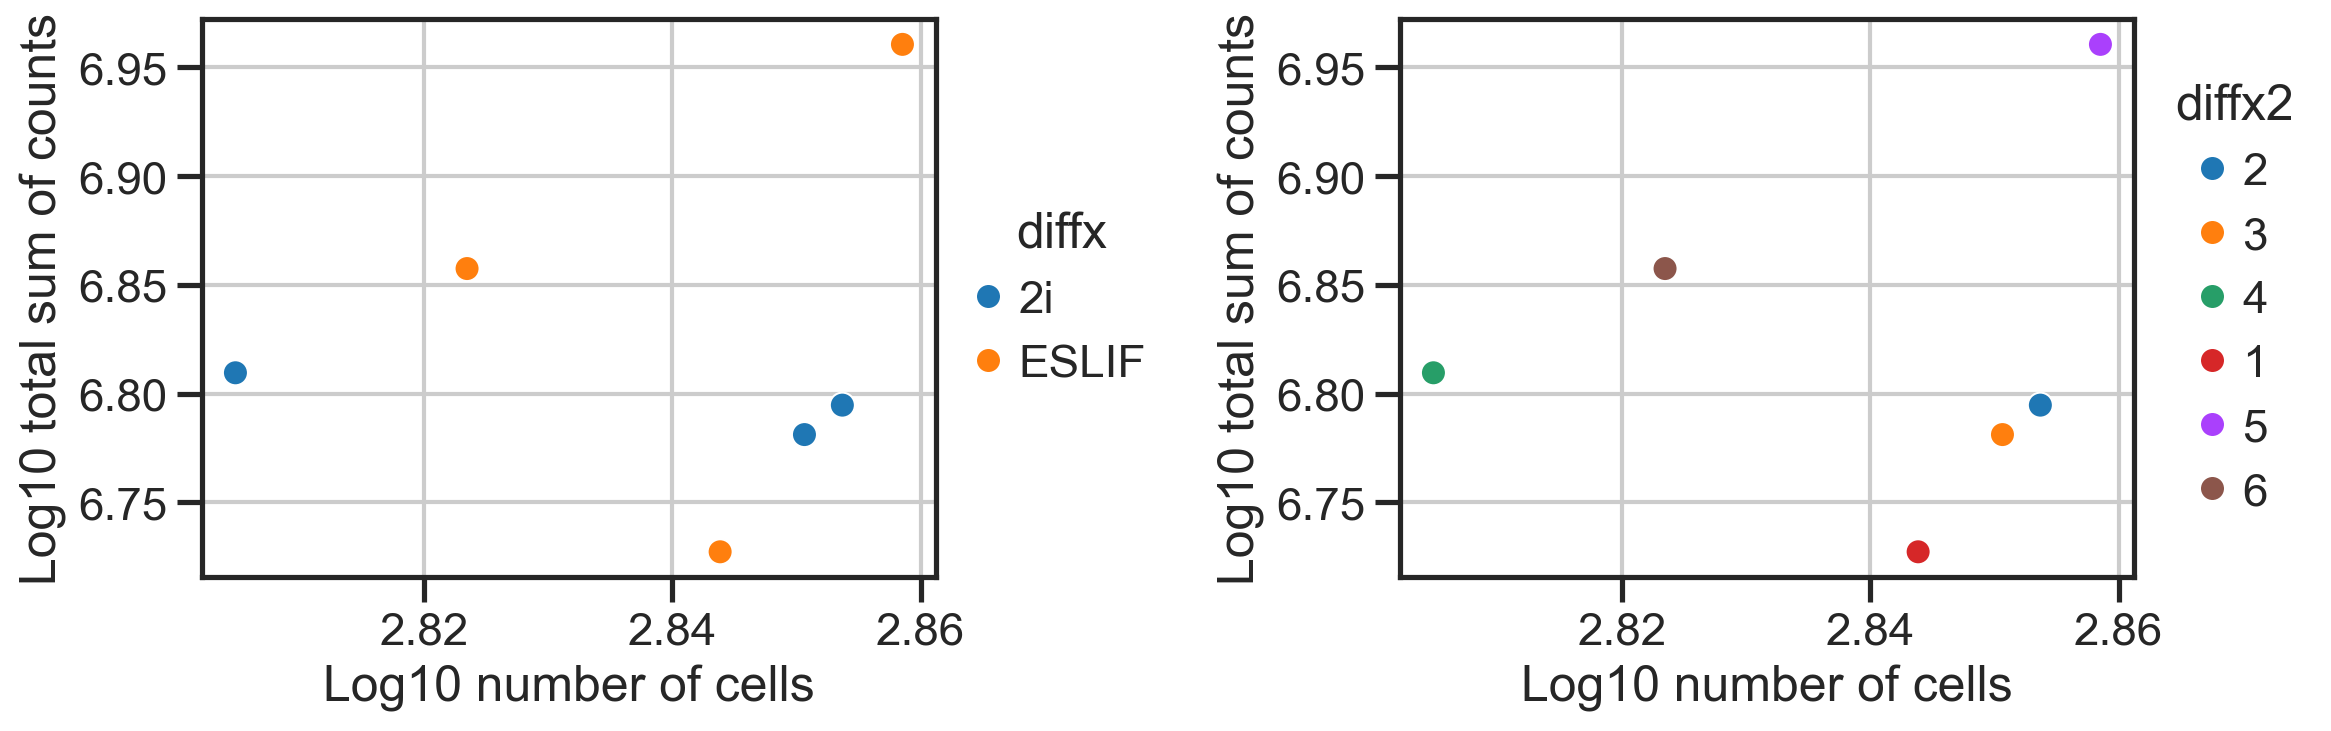

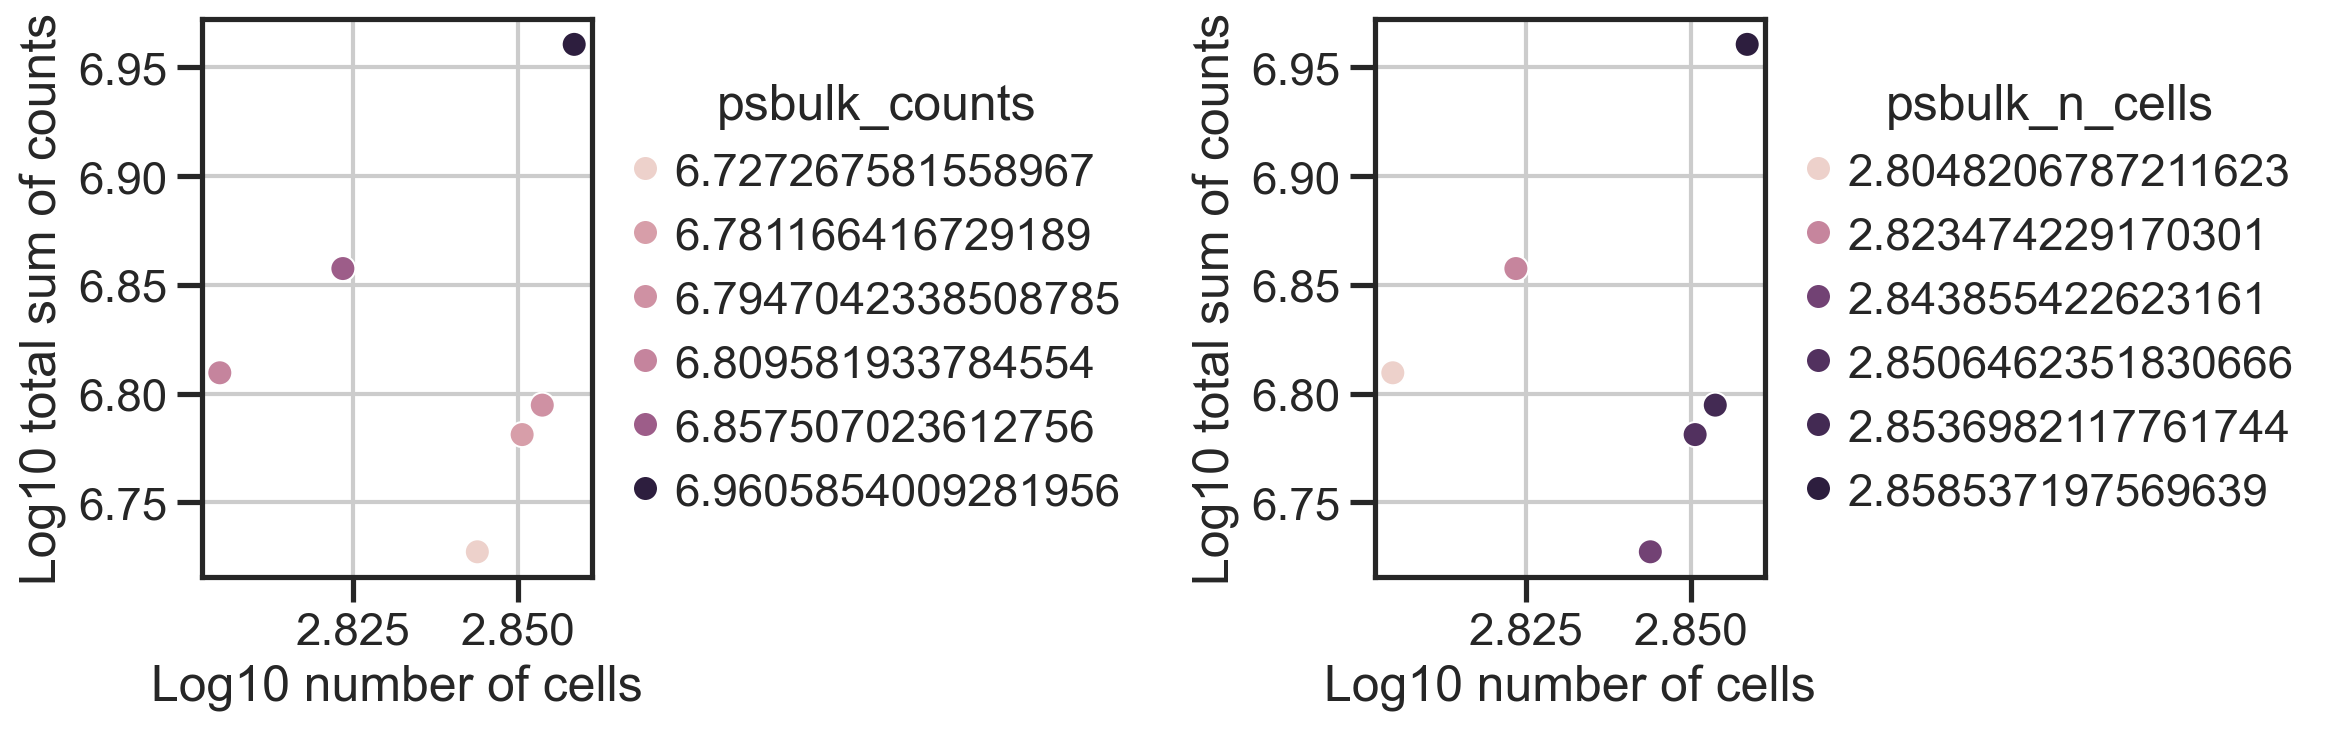

In [44]:
dc.plot_psbulk_samples(pdata, groupby=['diffx','diffx2'],figsize=(12, 4))

dc.plot_psbulk_samples(pdata, groupby=['psbulk_counts','psbulk_n_cells'], figsize=(12, 4))



<Axes: ylabel='Count'>

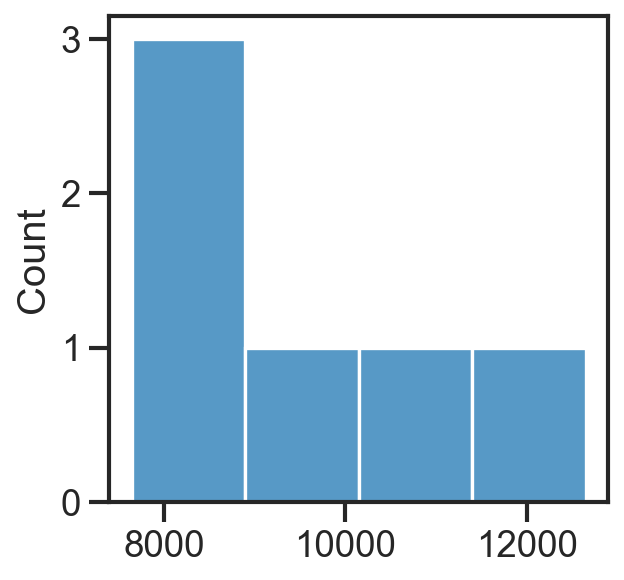

In [45]:
sns.histplot(pdata.obs['psbulk_counts']/pdata.obs['psbulk_n_cells'])

### filter pseudobulks

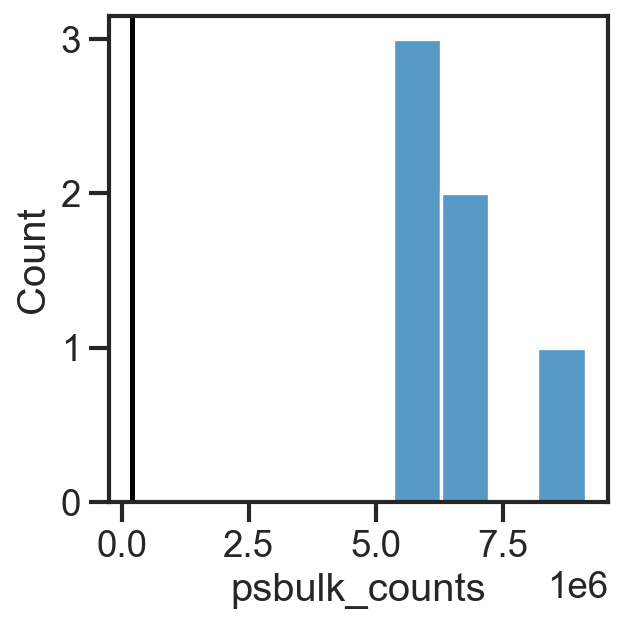

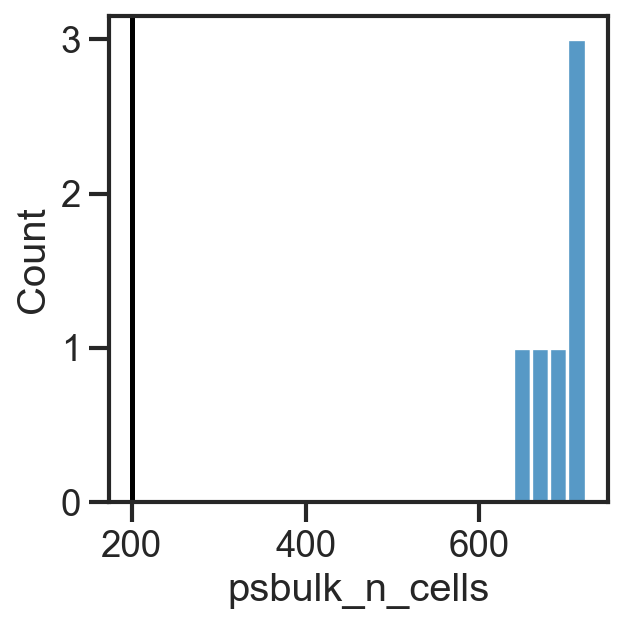

In [46]:
sns.histplot(pdata.obs['psbulk_counts'], bins = 4)
plt.axvline(200000, color = 'black')
plt.show()
sns.histplot(pdata.obs['psbulk_n_cells'], bins = 4)
plt.axvline(200, color = 'black')

In [47]:
# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata,
    groups_col='diffx',
    sample_col='diffx2',
    mode='sum',
    min_cells=200,
    min_counts=200000
)

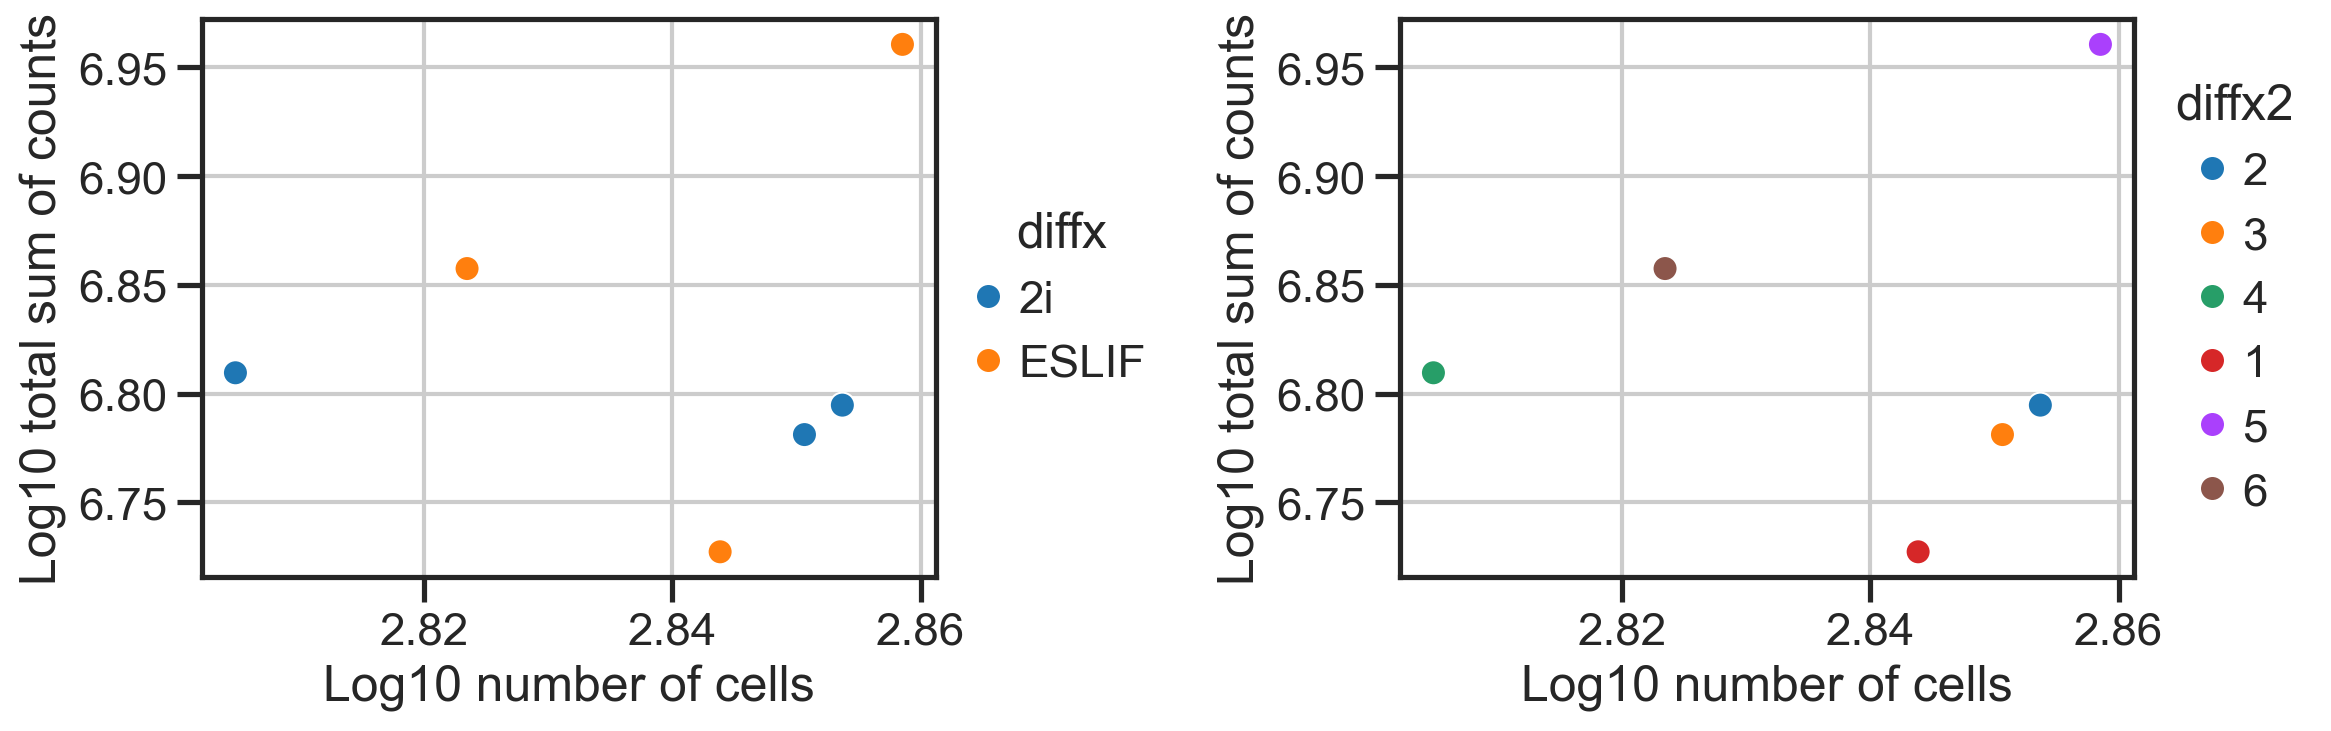

In [48]:
dc.plot_psbulk_samples(pdata, groupby=['diffx','diffx2'],figsize=(12, 4))


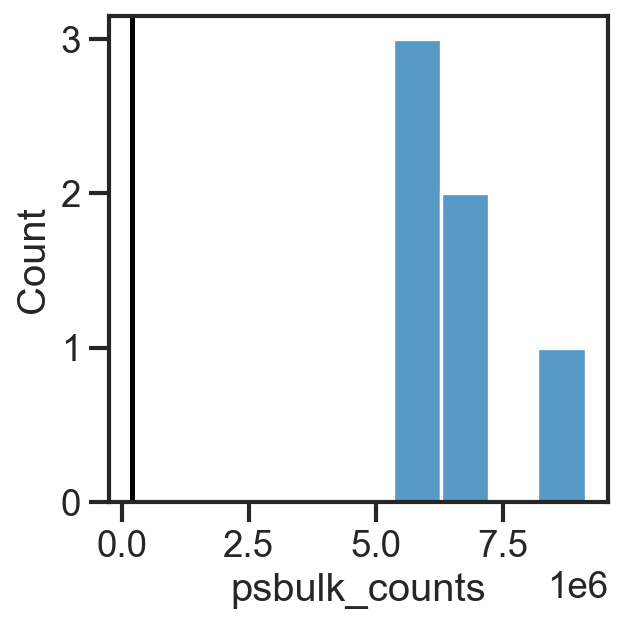

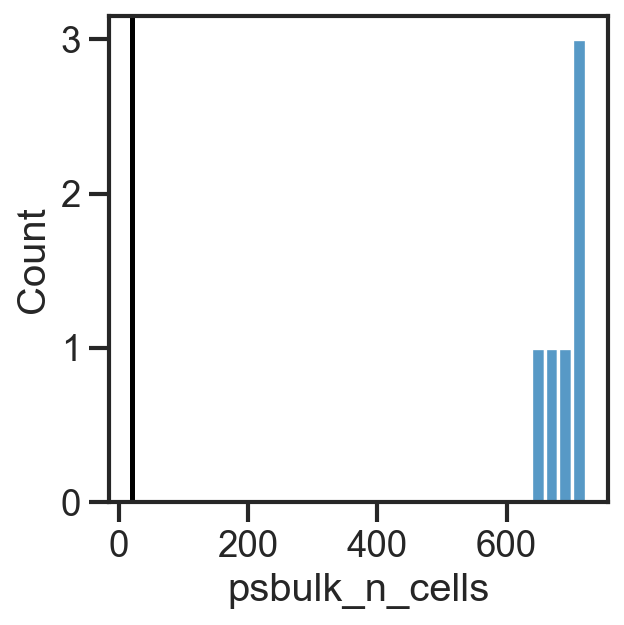

In [49]:
sns.histplot(pdata.obs['psbulk_counts'], bins = 4)
plt.axvline(200000, color = 'black')
plt.show()
sns.histplot(pdata.obs['psbulk_n_cells'], bins = 4)
plt.axvline(20, color = 'black')

### normalise and log-transform counts

In [50]:
# Store raw counts in layers
pdata.layers['counts'] = pdata.X.copy()

# Normalize, scale and compute pca
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value=10)
sc.tl.pca(pdata)

# Return raw counts to X
dc.swap_layer(pdata, 'counts', X_layer_key=None, inplace=True)


normalizing counts per cell
    finished (0:00:00)
computing PCA
    on highly variable genes
    with n_comps=5
    finished (0:00:00)


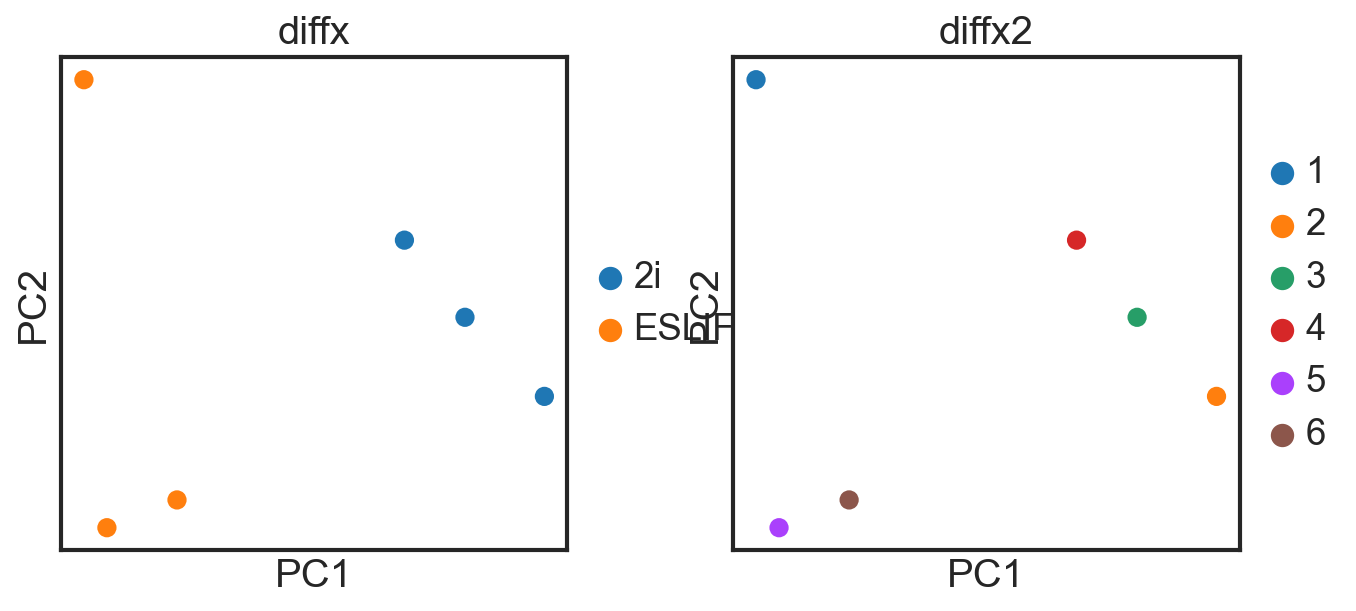

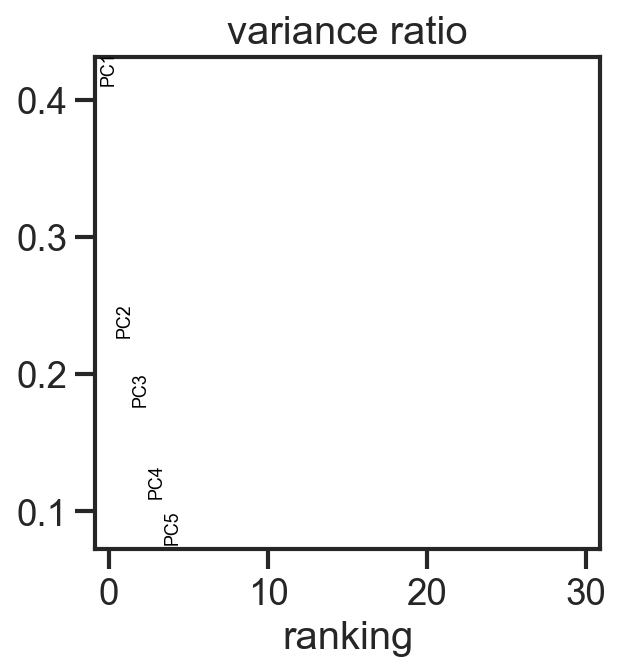

In [51]:
pdata.obs['diffx2'] = pdata.obs['diffx2'].astype('category')
sc.pl.pca(pdata, color=['diffx','diffx2'], ncols=3, size=300)
sc.pl.pca_variance_ratio(pdata)



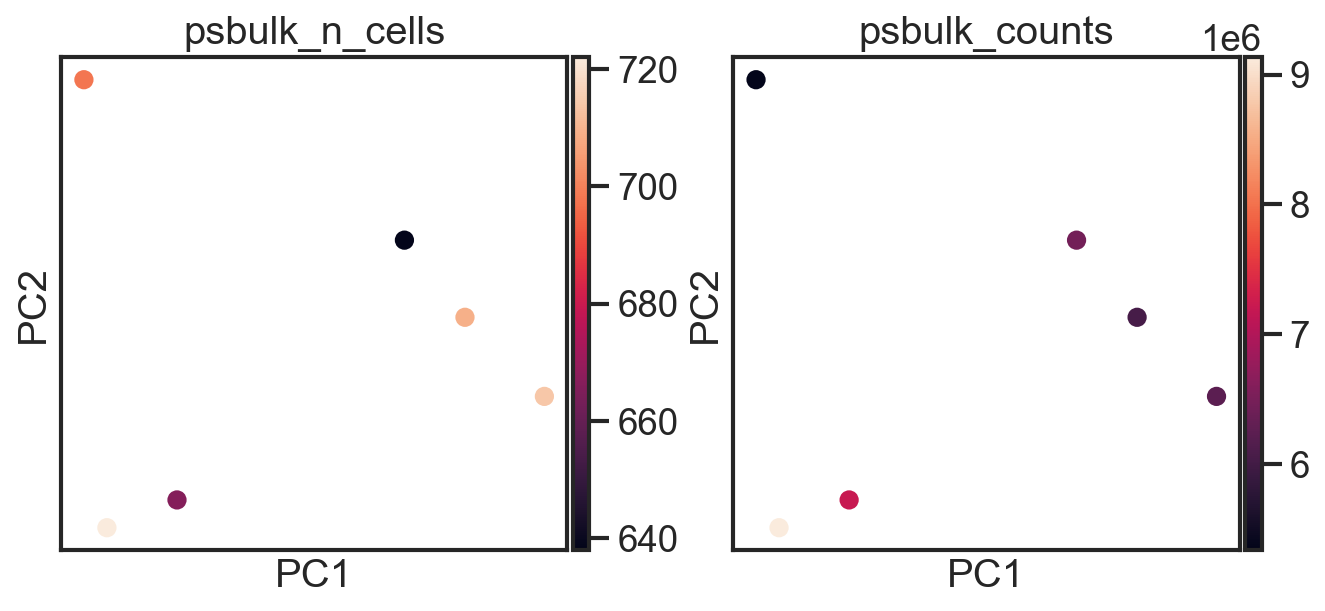

In [52]:
sc.pl.pca(pdata, color=['psbulk_n_cells', 'psbulk_counts'], ncols=3, size=300)


### perform feature (gene) filtering

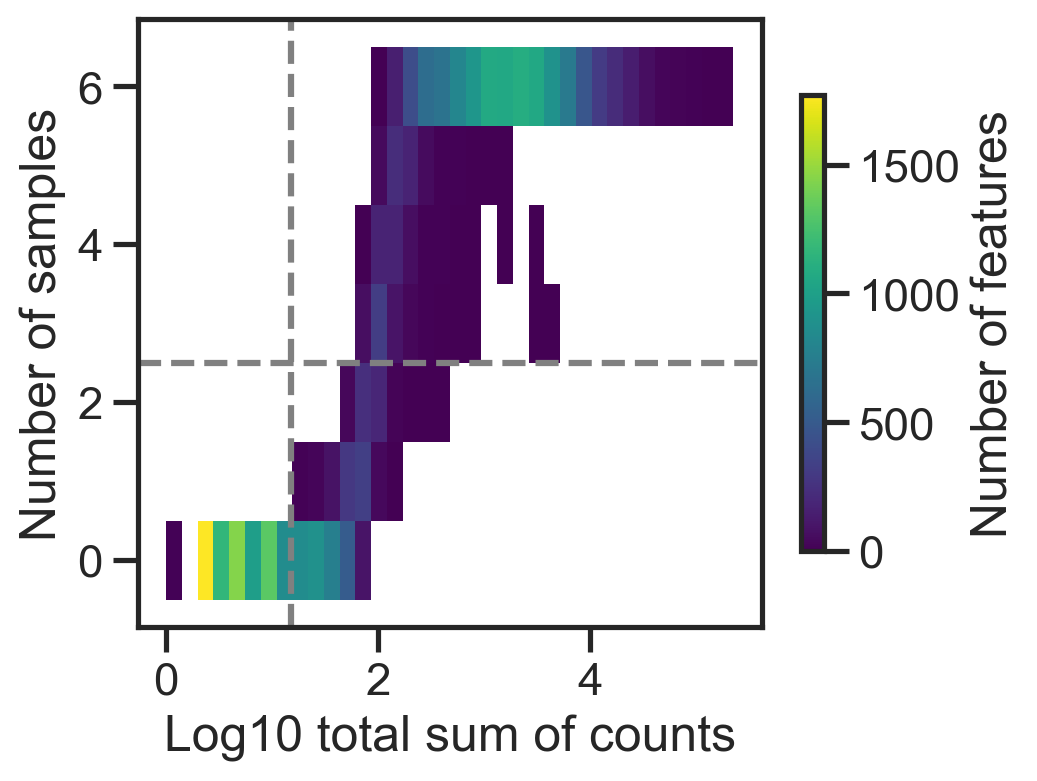

In [53]:
dc.plot_filter_by_expr(pdata, group='diffx', min_count=15, min_total_count=15)

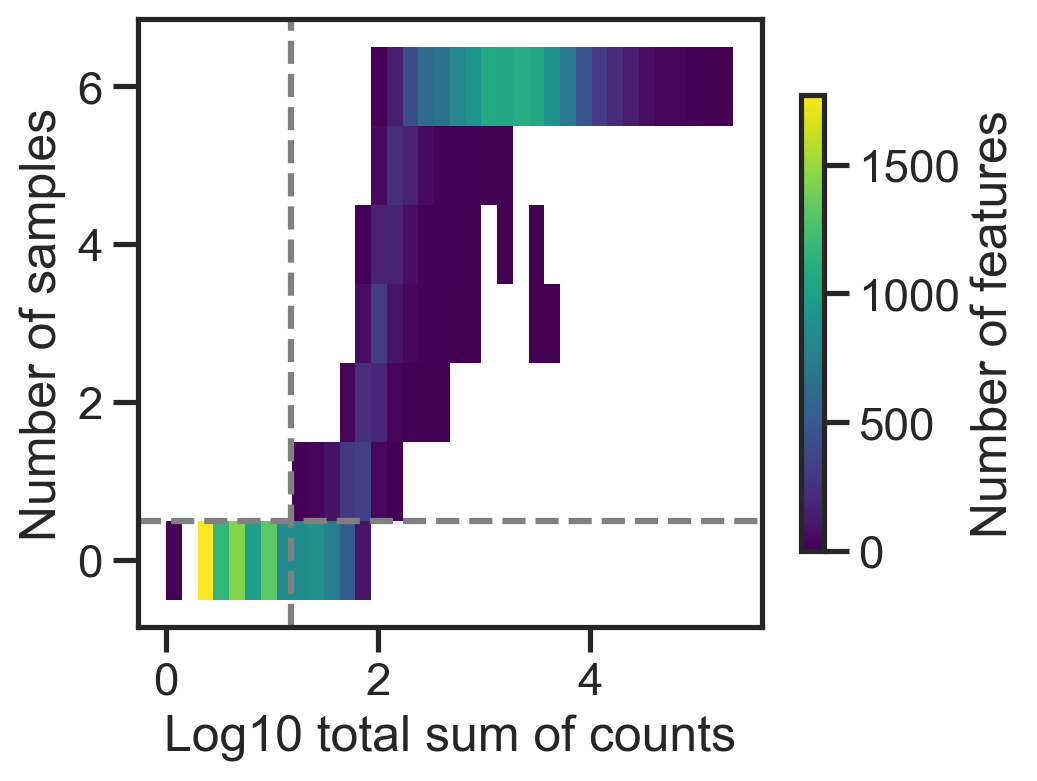

In [54]:
dc.plot_filter_by_expr(pdata, group='diffx2', min_count=15, min_total_count=15)

In [55]:
pdata

AnnData object with n_obs × n_vars = 6 × 24136
    obs: 'batch', 'name', 'condition', 'Condition', 'diffx', 'diffx2', 'psbulk_n_cells', 'psbulk_counts'
    var: 'ensembl', 'chromosome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'ensembl_chrom'
    uns: 'log1p', 'pca', 'diffx_colors', 'diffx2_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props', 'counts'

In [56]:
# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(pdata, group='diffx2', min_count=15, min_total_count=15)

# Filter by these genes
pdata = pdata[:, genes].copy()
pdata

AnnData object with n_obs × n_vars = 6 × 13495
    obs: 'batch', 'name', 'condition', 'Condition', 'diffx', 'diffx2', 'psbulk_n_cells', 'psbulk_counts'
    var: 'ensembl', 'chromosome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'ensembl_chrom'
    uns: 'log1p', 'pca', 'diffx_colors', 'diffx2_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props', 'counts'

### start DEseq differential analysis

In [57]:
# Build DESeq2 object
inference = DefaultInference(n_cpus=1)
dds = DeseqDataSet(
    adata=pdata,
    design_factors='diffx',
    ref_level=['diffx', 'ESLIF'],
    refit_cooks=True,
    inference=inference,
)

In [58]:
# Compute LFCs
dds.deseq2()

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 208.54 seconds.

Fitting dispersion trend curve...
... done in 1.00 seconds.

Fitting MAP dispersions...
... done in 207.12 seconds.

Fitting LFCs...
... done in 13.30 seconds.

Refitting 0 outliers.



In [59]:
# Extract contrast between LINS vs ESC
stat_res = DeseqStats(
    dds,
    contrast=["diffx", 'ESLIF','2i' ],
    inference=inference,
)

In [60]:
# Compute Wald test
stat_res.summary()


Running Wald tests...


Log2 fold change & Wald test p-value: diffx ESLIF vs 2i
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610005C13Rik   14.774295        0.617409  0.727853  0.848260  0.396293   
0610009B22Rik  314.260193        0.100537  0.113205  0.888100  0.374487   
0610010F05Rik  160.964645        0.894137  0.289180  3.091977  0.001988   
0610012G03Rik  301.914673       -0.359996  0.146923 -2.450238  0.014276   
0610030E20Rik  118.577080       -0.228954  0.230543 -0.993110  0.320657   
...                   ...             ...       ...       ...       ...   
Zyg11a          19.643398       -0.479104  0.267941 -1.788093  0.073761   
Zyg11b         346.717865       -0.507631  0.132005 -3.845539  0.000120   
Zyx            105.665375        0.682533  0.313424  2.177664  0.029431   
Zzef1          217.249680        0.657821  0.166699  3.946156  0.000079   
Zzz3           833.488525       -0.036356  0.116164 -0.312973  0.754301   

                   padj  
0610005C13Rik  0.

... done in 4.30 seconds.



In [61]:
# Extract results
results_df = stat_res.results_df
results_df.head(2)

baseMean  log2FoldChange     lfcSE     stat    pvalue  \
0610005C13Rik   14.774295        0.617409  0.727853  0.84826  0.396293   
0610009B22Rik  314.260193        0.100537  0.113205  0.88810  0.374487   

                   padj  
0610005C13Rik  0.611677  
0610009B22Rik  0.592740

In [62]:
results_df.loc[['Jarid2','Utf1','Phc1']]

baseMean  log2FoldChange     lfcSE       stat        pvalue  \
Jarid2  2890.389648        1.481488  0.196062   7.556238  4.148936e-14   
Utf1    3077.026611        5.123569  0.538832   9.508652  1.931483e-21   
Phc1    2609.795654        1.270274  0.124655  10.190353  2.189684e-24   

                padj  
Jarid2  3.393327e-12  
Utf1    3.620190e-19  
Phc1    5.094790e-22

In [63]:
results_df['p_log'] = -np.log10(results_df['padj'])

In [64]:
results_df.loc['Jarid2']['p_log']

11.469374333743103

In [65]:
genes = list(results_df.sort_values(by='padj')[0:25].index) + ['Jarid2','Phc1','Utf1']

#### make plot in fig2C

Text(0, 0.5, '')

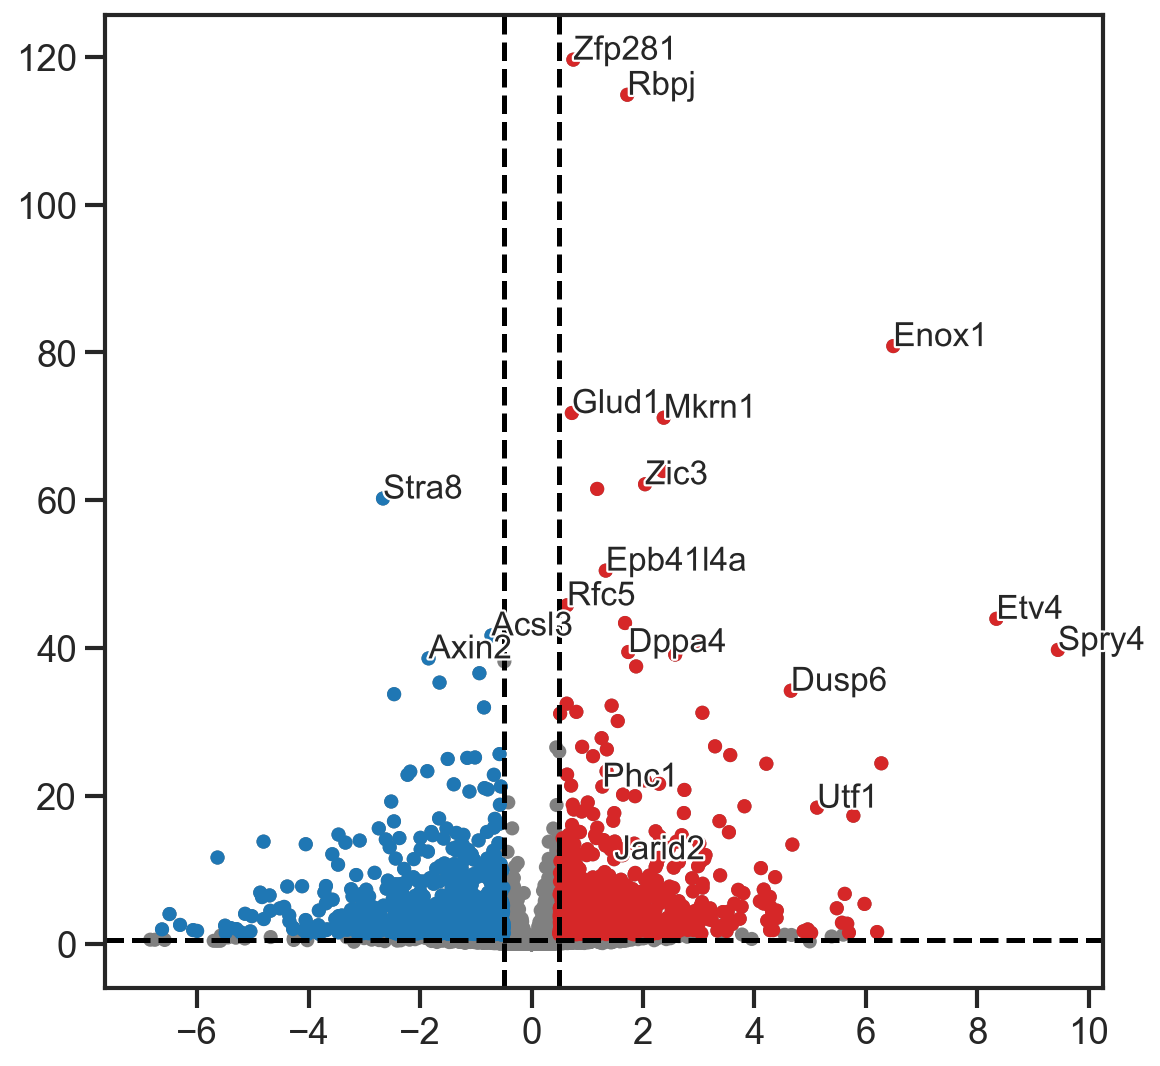

In [67]:
import matplotlib.patheffects as pe
sns.set_context('talk')
sns.set_style('white')
sns.set_style('ticks')
top = 20
sign_thr=0.05
lFCs_thr=0.5
color_pos='#D62728'
color_neg='#1F77B4'
color_null='gray'
genes2 = ['Zfp281', 'Rbpj', 'Enox1', 'Glud1', 'Mkrn1',      
 #'Hmces',
 'Zic3',
# 'Tns3',
 'Stra8', 'Epb41l4a', 'Rfc5', 'Etv4',
# 'Ltbp4',
 'Acsl3',
# 'Eras',
 'Spry4', 'Dppa4',
# 'Parvb',
 'Axin2',
# 'Tuba1c',  #'Slc25a40', #'Me1', #'Plcl2',
 'Dusp6',
# 'Cdkn1a',
 'Jarid2', 'Phc1', 'Utf1']
fig, ax = plt.subplots(figsize = (8,8))
genes = list(results_df.sort_values(by='padj')[0:top].index) + ['Jarid2','Phc1','Utf1']
sns.scatterplot(data = results_df,
                   x='log2FoldChange',linewidth = 0,ax=ax,
                y='p_log', size = 1, color = color_null)

sns.scatterplot(data = results_df[(results_df['padj'] < 0.05) & (results_df['log2FoldChange'] < -0.5) ],
                   x='log2FoldChange',linewidth = 0,ax=ax,
                y='p_log', size = 1, color = color_neg)

sns.scatterplot(data = results_df[(results_df['padj'] < 0.05) & (results_df['log2FoldChange'] > 0.5) ],
                   x='log2FoldChange',linewidth = 0,ax=ax,
                y='p_log', size = 1, color = color_pos)

ax.axhline(lFCs_thr, color = 'black', linestyle = 'dashed')
ax.axvline(lFCs_thr, color = 'black', linestyle = 'dashed')
ax.axvline(-lFCs_thr, color = 'black', linestyle = 'dashed')


for gene in genes2:
    plt.text(results_df.loc[gene]['log2FoldChange'],results_df.loc[gene]['p_log'],gene, size = 15,
            path_effects=[pe.withStroke(linewidth=2, foreground="white")]) 
ax.legend([],frameon = False)
ax.set_xlabel('')#Log Fold Change')
ax.set_ylabel('')#Adjusted p-value [-log10]')

#plt.savefig('20240430_volcano_nolabel.png',dpi=300)

# Volcano plots for different gene clusters

#### Make plots in S3D

In [90]:
table = pd.read_csv(pathToData + 'compM_mm10geneStarts_clustered.bed', sep = '\t')
table['ensembl'] = [ob for ob in table['name'].str.split('.', expand = True)[0]]
table.head(2)

#chrom    start      end                  name  score strand  thickStart  \
0      14  5894001  5904001  ENSMUSG00000079379.2    0.0      -     5894001   
1      14  6884962  6894962  ENSMUSG00000090691.3    0.0      -     6884962   

   thickEnd  itemRGB  blockCount  blockSizes  blockStart deepTools_group  \
0   5904001        0           1       10000     5893996       cluster_1   
1   6894962        0           1       10000     6884956       cluster_1   

              ensembl  
0  ENSMUSG00000079379  
1  ENSMUSG00000090691

In [91]:
cluster1 = list(table[table['deepTools_group'] =='cluster_1']['ensembl'])
cluster2 = list(table[table['deepTools_group'] =='cluster_2']['ensembl'])
cluster3 = list(table[table['deepTools_group'] =='cluster_3']['ensembl'])
cluster4 = list(table[table['deepTools_group'] =='cluster_4']['ensembl'])
allgenes = list(table['ensembl'])

print(len(cluster1), len(cluster1)/len(allgenes))
print(len(cluster2), len(cluster2)/len(allgenes))
print(len(cluster3), len(cluster3)/len(allgenes))
print(len(cluster4), len(cluster4)/len(allgenes))
print(len(allgenes), len(allgenes)/len(allgenes))

7983 0.1620255733712198
11065 0.22457885122792776
16206 0.3289222650700223
14016 0.2844733103308301
49270 1.0


In [92]:
c1 = pd.DataFrame([cluster1]).T
c1['cluster'] = 'cluster1'
c2 = pd.DataFrame([cluster2]).T
c2['cluster'] = 'cluster2'
c3 = pd.DataFrame([cluster3]).T
c3['cluster'] = 'cluster3'
c4 = pd.DataFrame([cluster4]).T
c4['cluster'] = 'cluster4'

all_clusters = pd.concat([c1,c2,c3,c4])
all_clusters.index = all_clusters[0]
all_clusters

0   cluster
0                                               
ENSMUSG00000079379  ENSMUSG00000079379  cluster1
ENSMUSG00000090691  ENSMUSG00000090691  cluster1
ENSMUSG00000025927  ENSMUSG00000025927  cluster1
ENSMUSG00000097910  ENSMUSG00000097910  cluster1
ENSMUSG00000109697  ENSMUSG00000109697  cluster1
...                                ...       ...
ENSMUSG00000083661  ENSMUSG00000083661  cluster4
ENSMUSG00000117824  ENSMUSG00000117824  cluster4
ENSMUSG00000096691  ENSMUSG00000096691  cluster4
ENSMUSG00000115502  ENSMUSG00000115502  cluster4
ENSMUSG00000117317  ENSMUSG00000117317  cluster4

[49270 rows x 2 columns]

In [93]:
results_df2 = results_df.copy()
results_df2['ensembl'] = adata.var['ensembl']
results_df2['gene'] = results_df2.index
results_df2.index = results_df2['ensembl']
results_df2['cluster'] = all_clusters['cluster']
results_df2.index = results_df2['gene']
results_df2.head(2)

baseMean  log2FoldChange     lfcSE     stat    pvalue  \
gene                                                                     
0610005C13Rik   14.774295        0.617409  0.727853  0.84826  0.396293   
0610009B22Rik  314.260193        0.100537  0.113205  0.88810  0.374487   

                   padj     p_log             ensembl           gene   cluster  
gene                                                                            
0610005C13Rik  0.611677  0.213478  ENSMUSG00000109644  0610005C13Rik  cluster4  
0610009B22Rik  0.592740  0.227136  ENSMUSG00000007777  0610009B22Rik  cluster4

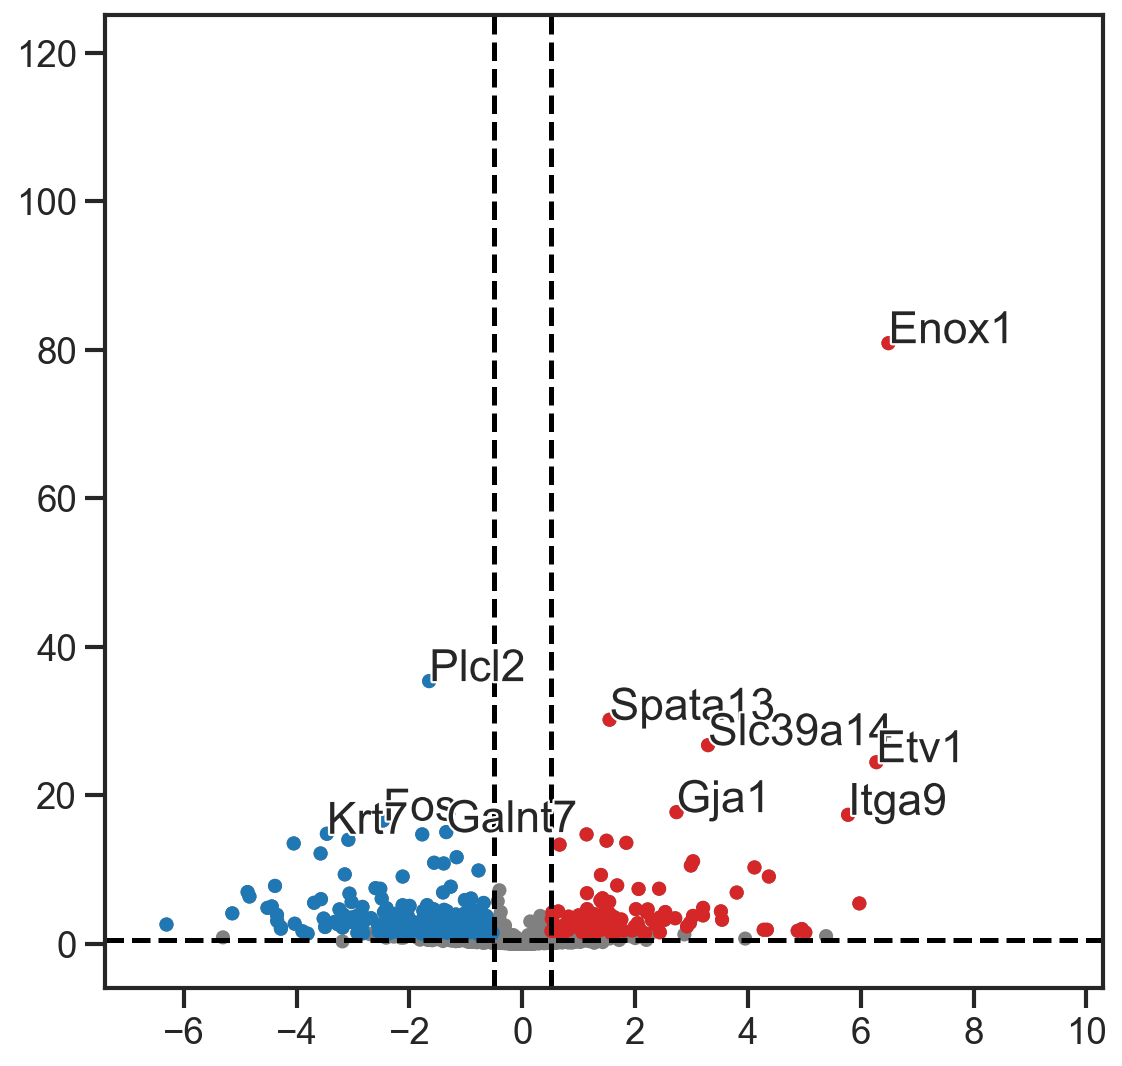

In [94]:
import matplotlib.patheffects as pe
sns.set_context('talk')
sns.set_style('white')
sns.set_style('ticks')
top = 10
sign_thr=0.05
lFCs_thr=0.5
color_pos='#D62728'
color_neg='#1F77B4'
color_null='gray'
genes2 = ['Zfp281', 'Rbpj', 'Enox1', 'Glud1', 'Mkrn1',      
 #'Hmces',
 'Zic3',
# 'Tns3',
 'Stra8', 'Epb41l4a', 'Rfc5', 'Etv4',
# 'Ltbp4',
 'Acsl3',
# 'Eras',
 'Spry4', 'Dppa4',
# 'Parvb',
 'Axin2',
# 'Tuba1c',  #'Slc25a40', #'Me1', #'Plcl2',
 'Dusp6',
# 'Cdkn1a',
 'Jarid2', 'Phc1', 'Utf1']

c1 = results_df2[results_df2['cluster'] == 'cluster1']

fig, ax = plt.subplots(figsize = (8,8))
genes = list(c1.sort_values(by='padj')[0:top].index) #+ ['Jarid2','Phc1','Utf1']
sns.scatterplot(data = c1,
                   x='log2FoldChange',linewidth = 0,ax=ax,
                y='p_log', size = 1, color = color_null)

sns.scatterplot(data = c1[(c1['padj'] < 0.05) & (c1['log2FoldChange'] < -0.5) ],
                   x='log2FoldChange',linewidth = 0,ax=ax,
                y='p_log', size = 1, color = color_neg)

sns.scatterplot(data = c1[(c1['padj'] < 0.05) & (c1['log2FoldChange'] > 0.5) ],
                   x='log2FoldChange',linewidth = 0,ax=ax,
                y='p_log', size = 1, color = color_pos)

ax.axhline(lFCs_thr, color = 'black', linestyle = 'dashed')
ax.axvline(lFCs_thr, color = 'black', linestyle = 'dashed')
ax.axvline(-lFCs_thr, color = 'black', linestyle = 'dashed')
ax.set_xlim([-7.4,10.3])
ax.set_ylim([-6,125])


for gene in genes:
    plt.text(c1.loc[gene]['log2FoldChange'],c1.loc[gene]['p_log'],gene, size = 20,
            path_effects=[pe.withStroke(linewidth=2, foreground="white")]) 
ax.legend([],frameon = False)
ax.set_xlabel('')#Log Fold Change')
ax.set_ylabel('')#Adjusted p-value [-log10]')

plt.savefig('figures/20240730_volcano_nolabel_c1.png',dpi=300)

In [95]:
print(len(c1))
print(len(c1[(c1['padj'] < 0.05) & (c1['log2FoldChange'] < -0.5) ]), len(c1[(c1['padj'] < 0.05) & (c1['log2FoldChange'] < -0.5) ])/len(c1)*100)
print(len(c1[(c1['padj'] < 0.05) & (c1['log2FoldChange'] > 0.5) ]), len(c1[(c1['padj'] < 0.05) & (c1['log2FoldChange'] > 0.5) ])/len(c1)*100)


1309
190 14.514896867838045
109 8.326967150496563


In [96]:
c1 = results_df2[results_df2['cluster'] == 'cluster2']
genes = list(c1.sort_values(by='padj')[0:12].index) #+ ['Jarid2','Phc1','Utf1']
genes

['Rbpj',
 'Etv4',
 'Spry4',
 'Cnpy1',
 'Bmp4',
 'Foxo6',
 'Tnfrsf19',
 'Utf1',
 'Spred1',
 'Dab1',
 'Gm13889',
 'S1pr1']

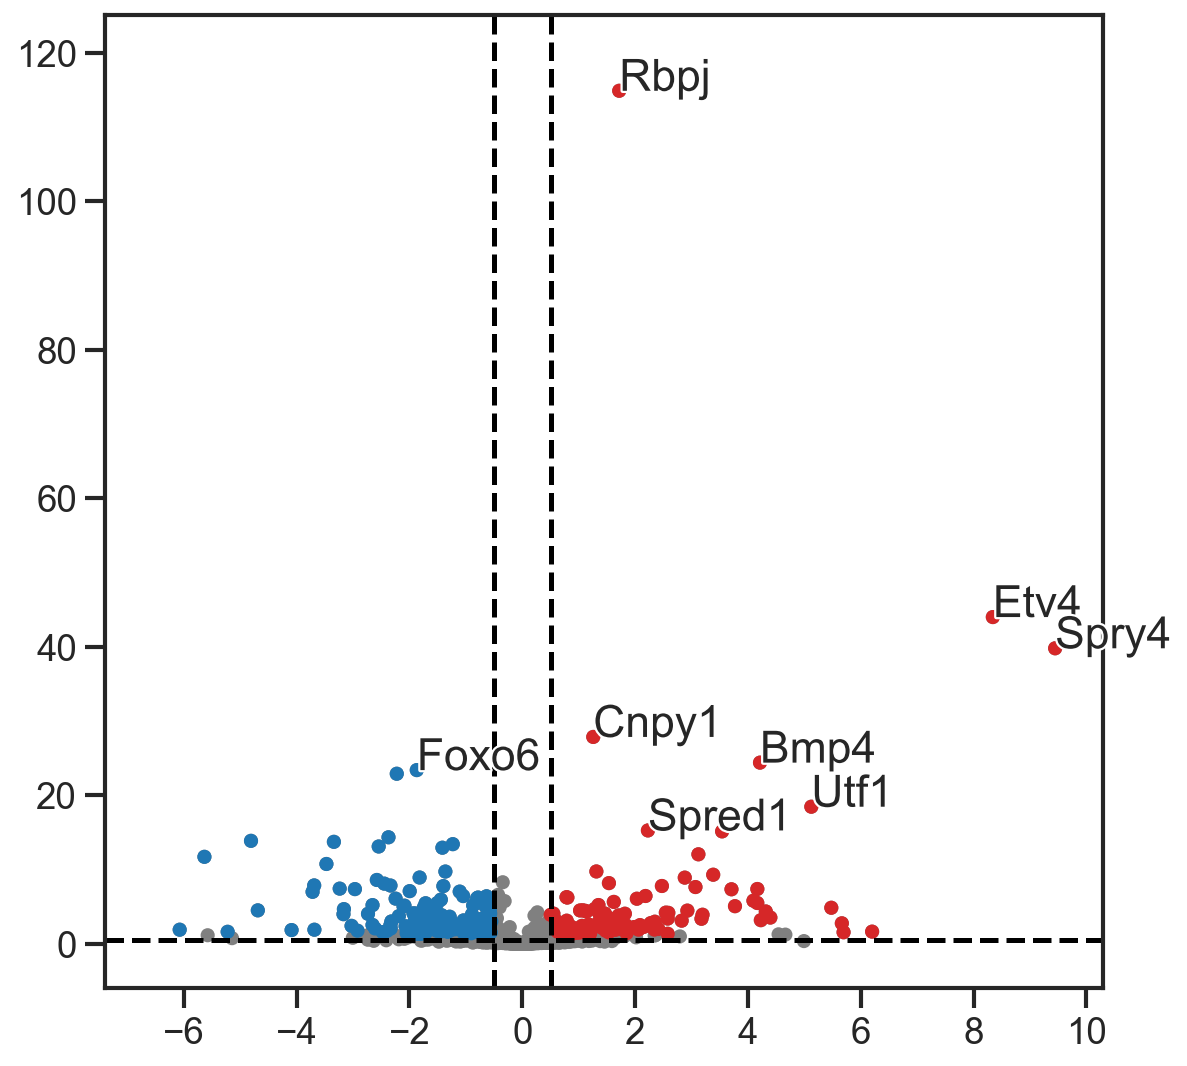

In [105]:
import matplotlib.patheffects as pe
sns.set_context('talk')
sns.set_style('white')
sns.set_style('ticks')
top = 10
sign_thr=0.05
lFCs_thr=0.5
color_pos='#D62728'
color_neg='#1F77B4'
color_null='gray'
genes2 = ['Rbpj',
 'Etv4',
 'Spry4',
 'Cnpy1',
 'Bmp4',
 'Foxo6',
 #'Tnfrsf19',
 'Utf1',
 'Spred1']
 #'Dab1']

c1 = results_df2[results_df2['cluster'] == 'cluster2']

fig, ax = plt.subplots(figsize = (8,8))
genes = list(c1.sort_values(by='padj')[0:top].index) #+ ['Jarid2','Phc1','Utf1']
sns.scatterplot(data = c1,
                   x='log2FoldChange',linewidth = 0,ax=ax,
                y='p_log', size = 1, color = color_null)

sns.scatterplot(data = c1[(c1['padj'] < 0.05) & (c1['log2FoldChange'] < -0.5) ],
                   x='log2FoldChange',linewidth = 0,ax=ax,
                y='p_log', size = 1, color = color_neg)

sns.scatterplot(data = c1[(c1['padj'] < 0.05) & (c1['log2FoldChange'] > 0.5) ],
                   x='log2FoldChange',linewidth = 0,ax=ax,
                y='p_log', size = 1, color = color_pos)

ax.axhline(lFCs_thr, color = 'black', linestyle = 'dashed')
ax.axvline(lFCs_thr, color = 'black', linestyle = 'dashed')
ax.axvline(-lFCs_thr, color = 'black', linestyle = 'dashed')
ax.set_xlim([-7.4,10.3])
ax.set_ylim([-6,125])


for gene in genes2:
    plt.text(c1.loc[gene]['log2FoldChange'],c1.loc[gene]['p_log'],gene, size = 20,
            path_effects=[pe.withStroke(linewidth=2, foreground="white")]) 
ax.legend([],frameon = False)
ax.set_xlabel('')#Log Fold Change')
ax.set_ylabel('')#Adjusted p-value [-log10]')

plt.savefig('figures/20240730_volcano_nolabel_c2.png',dpi=300, bbox_inches='tight')

In [98]:
print(len(c1))
print(len(c1[(c1['padj'] < 0.05) & (c1['log2FoldChange'] < -0.5) ]), len(c1[(c1['padj'] < 0.05) & (c1['log2FoldChange'] < -0.5) ])/len(c1)*100)
print(len(c1[(c1['padj'] < 0.05) & (c1['log2FoldChange'] > 0.5) ]), len(c1[(c1['padj'] < 0.05) & (c1['log2FoldChange'] > 0.5) ])/len(c1)*100)


1115
138 12.376681614349776
105 9.417040358744394


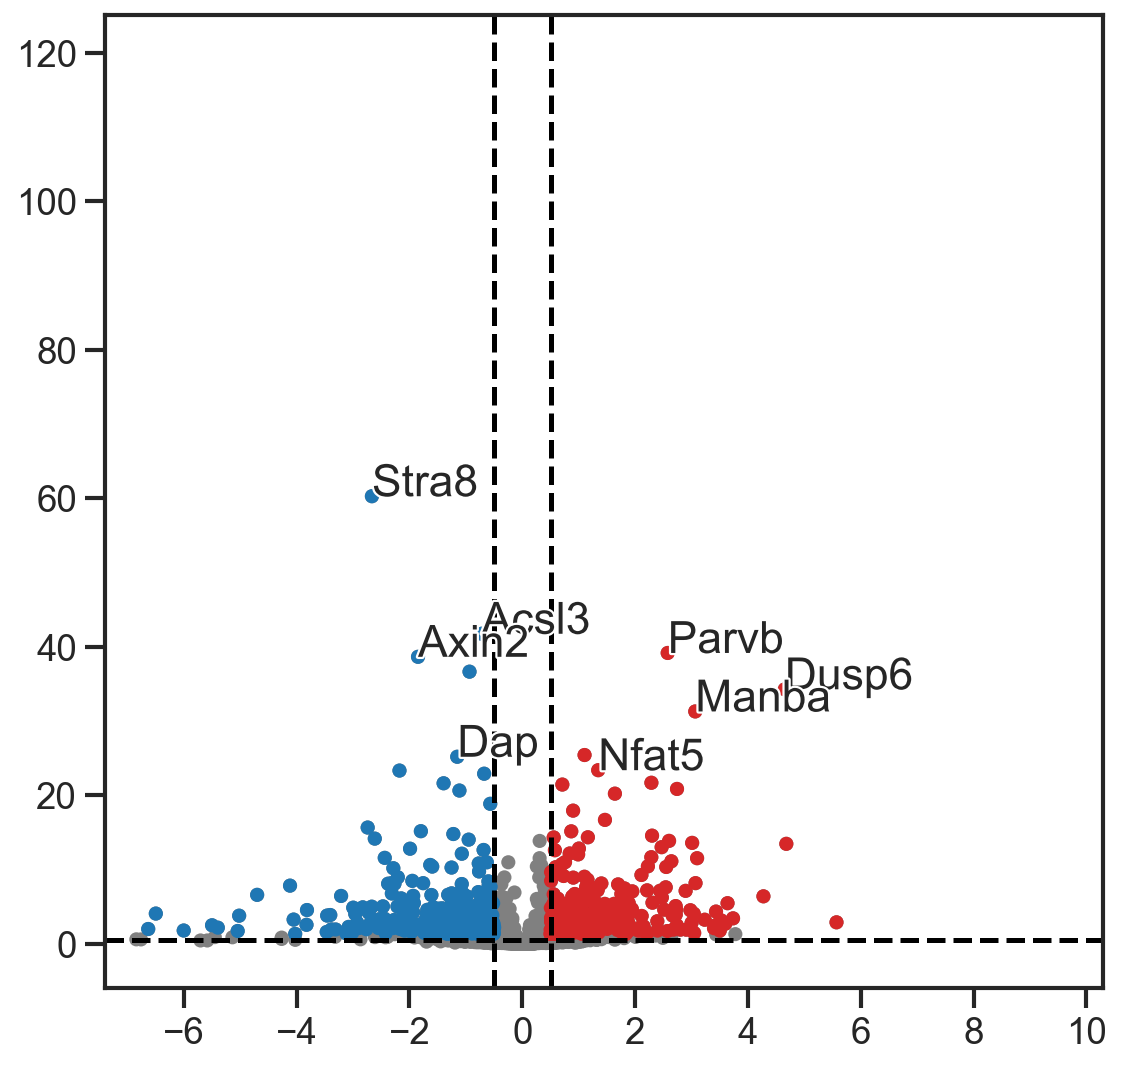

In [99]:
import matplotlib.patheffects as pe
sns.set_context('talk')
sns.set_style('white')
sns.set_style('ticks')
top = 10
sign_thr=0.05
lFCs_thr=0.5
color_pos='#D62728'
color_neg='#1F77B4'
color_null='gray'
genes2 = ['Stra8','Acsl3','Axin2','Dap','Parvb','Dusp6',  'Manba', 'Nfat5']

c1 = results_df2[results_df2['cluster'] == 'cluster3']

fig, ax = plt.subplots(figsize = (8,8))
genes = list(c1.sort_values(by='padj')[0:top].index) #+ ['Jarid2','Phc1','Utf1']
sns.scatterplot(data = c1,
                   x='log2FoldChange',linewidth = 0,ax=ax,
                y='p_log', size = 1, color = color_null)

sns.scatterplot(data = c1[(c1['padj'] < 0.05) & (c1['log2FoldChange'] < -0.5) ],
                   x='log2FoldChange',linewidth = 0,ax=ax,
                y='p_log', size = 1, color = color_neg)

sns.scatterplot(data = c1[(c1['padj'] < 0.05) & (c1['log2FoldChange'] > 0.5) ],
                   x='log2FoldChange',linewidth = 0,ax=ax,
                y='p_log', size = 1, color = color_pos)

ax.axhline(lFCs_thr, color = 'black', linestyle = 'dashed')
ax.axvline(lFCs_thr, color = 'black', linestyle = 'dashed')
ax.axvline(-lFCs_thr, color = 'black', linestyle = 'dashed')
ax.set_xlim([-7.4,10.3])
ax.set_ylim([-6,125])


for gene in genes2:
    plt.text(c1.loc[gene]['log2FoldChange'],c1.loc[gene]['p_log'],gene, size = 20,
            path_effects=[pe.withStroke(linewidth=2, foreground="white")]) 
ax.legend([],frameon = False)
ax.set_xlabel('')#Log Fold Change')
ax.set_ylabel('')#Adjusted p-value [-log10]')

plt.savefig('figures/20240730_volcano_nolabel_c3.png',dpi=300)

In [100]:
print(len(c1))
print(len(c1[(c1['padj'] < 0.05) & (c1['log2FoldChange'] < -0.5) ]), len(c1[(c1['padj'] < 0.05) & (c1['log2FoldChange'] < -0.5) ])/len(c1)*100)
print(len(c1[(c1['padj'] < 0.05) & (c1['log2FoldChange'] > 0.5) ]), len(c1[(c1['padj'] < 0.05) & (c1['log2FoldChange'] > 0.5) ])/len(c1)*100)


4004
360 8.991008991008991
296 7.392607392607392


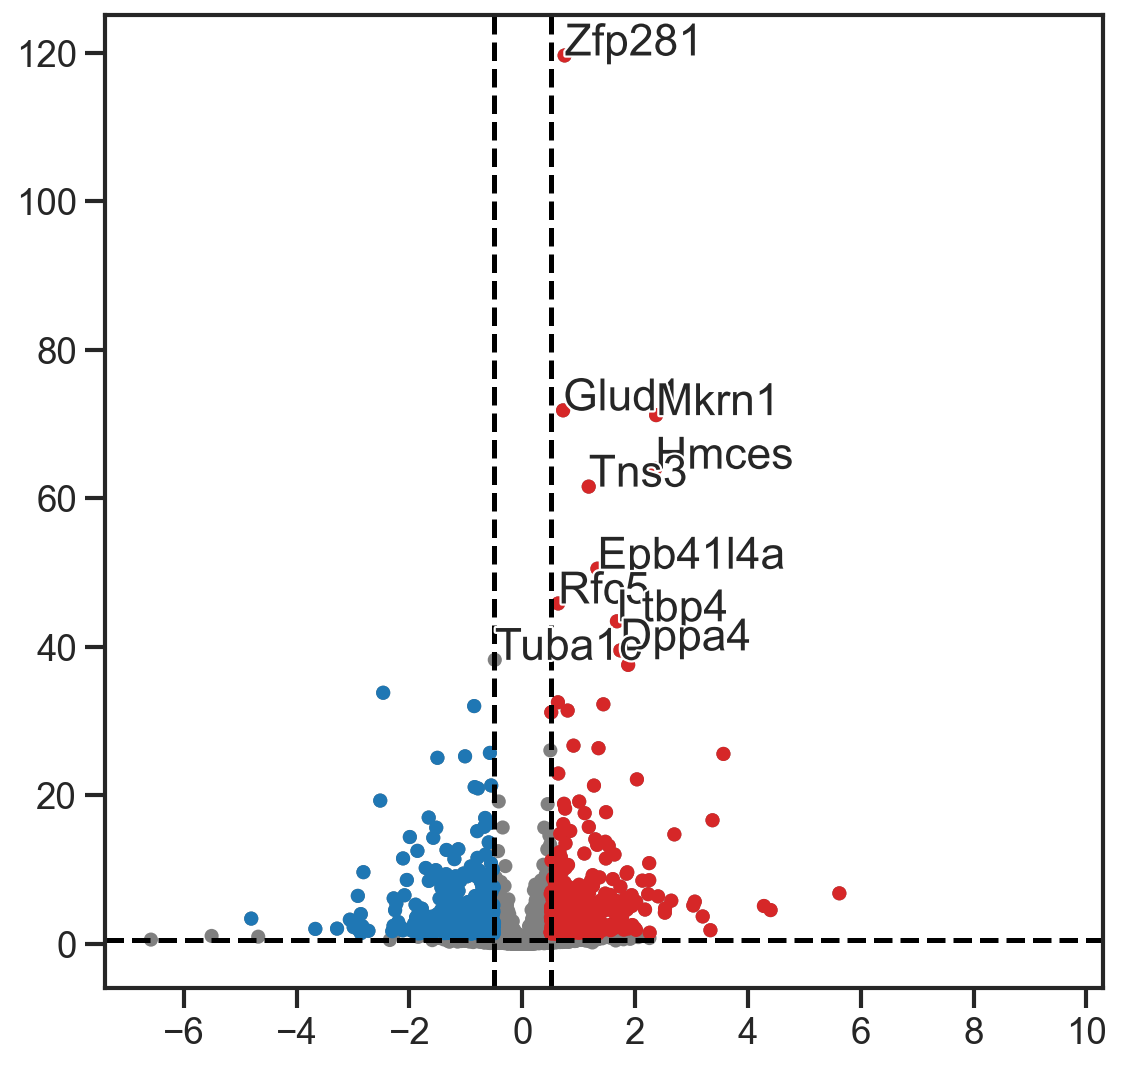

In [101]:
import matplotlib.patheffects as pe
sns.set_context('talk')
sns.set_style('white')
sns.set_style('ticks')
top = 10
sign_thr=0.05
lFCs_thr=0.5
color_pos='#D62728'
color_neg='#1F77B4'
color_null='gray'

c1 = results_df2[results_df2['cluster'] == 'cluster4']

fig, ax = plt.subplots(figsize = (8,8))
genes = list(c1.sort_values(by='padj')[0:top].index) #+ ['Jarid2','Phc1','Utf1']
sns.scatterplot(data = c1,
                   x='log2FoldChange',linewidth = 0,ax=ax,
                y='p_log', size = 1, color = color_null)

sns.scatterplot(data = c1[(c1['padj'] < 0.05) & (c1['log2FoldChange'] < -0.5) ],
                   x='log2FoldChange',linewidth = 0,ax=ax,
                y='p_log', size = 1, color = color_neg)

sns.scatterplot(data = c1[(c1['padj'] < 0.05) & (c1['log2FoldChange'] > 0.5) ],
                   x='log2FoldChange',linewidth = 0,ax=ax,
                y='p_log', size = 1, color = color_pos)

ax.axhline(lFCs_thr, color = 'black', linestyle = 'dashed')
ax.axvline(lFCs_thr, color = 'black', linestyle = 'dashed')
ax.axvline(-lFCs_thr, color = 'black', linestyle = 'dashed')
ax.set_xlim([-7.4,10.3])
ax.set_ylim([-6,125])


for gene in genes:
    plt.text(c1.loc[gene]['log2FoldChange'],c1.loc[gene]['p_log'],gene, size = 20,
            path_effects=[pe.withStroke(linewidth=2, foreground="white")]) 
ax.legend([],frameon = False)
ax.set_xlabel('')#Log Fold Change')
ax.set_ylabel('')#Adjusted p-value [-log10]')

plt.savefig('figures/20240730_volcano_nolabel_c4.png',dpi=300)

In [102]:
print(len(c1))
print(len(c1[(c1['padj'] < 0.05) & (c1['log2FoldChange'] < -0.5) ]), len(c1[(c1['padj'] < 0.05) & (c1['log2FoldChange'] < -0.5) ])/len(c1)*100)
print(len(c1[(c1['padj'] < 0.05) & (c1['log2FoldChange'] > 0.5) ]), len(c1[(c1['padj'] < 0.05) & (c1['log2FoldChange'] > 0.5) ])/len(c1)*100)


6422
385 5.9950171286203675
384 5.979445655559016


In [103]:
3095/4004 * 100

77.2977022977023

In [104]:
results_df2[(results_df2['padj'] > 0.05) ]['cluster'].value_counts()

cluster4    5149
cluster3    3095
cluster1     981
cluster2     851
Name: cluster, dtype: int64

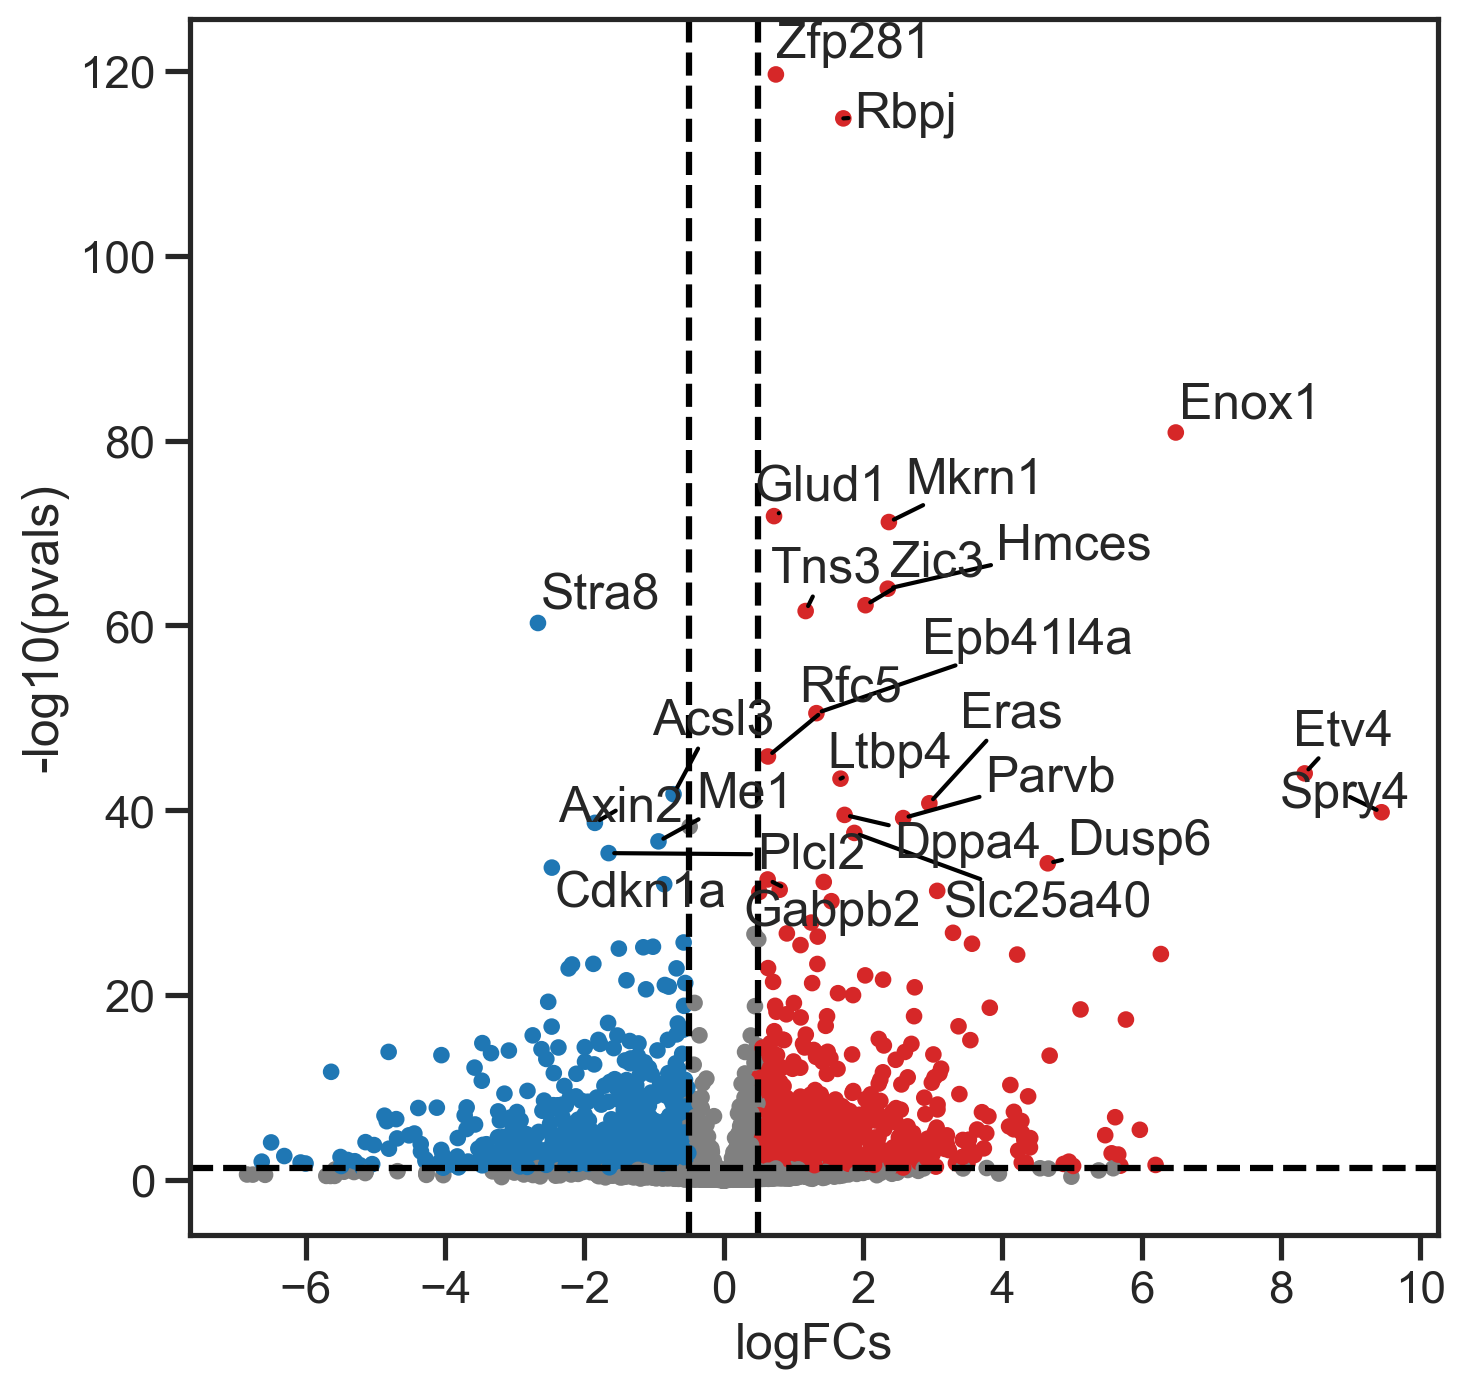

In [357]:
dc.plot_volcano_df(
    results_df,
    x='log2FoldChange',
    y='padj',
    top=25,
    name = 'Jarid2',
    figsize=(8,8),save='volcano_2ivsESLIF.png'
)


In [200]:
# Retrieve CollecTRI gene regulatory network
#collectri = dc.get_collectri(organism='mouse', split_complexes=False)
collectri = pd.read_csv('/Users/m.blotenburg/Documents/Projects/TCHIC/data/jupyter_notebooks/2024/fig4/20240229_GRN_all.csv',index_col=0)

collectri.head(2)

source target  weight
0    Myc   Tert       1
1   Spi1  Bglap       1

In [202]:
mat = results_df[['stat']].rename(columns={'stat': 'ESC'})
mat = mat.T
mat

0610005C13Rik  0610009B22Rik  0610010F05Rik  0610012G03Rik  \
ESC        0.84826         0.8881       3.091977      -2.450238   

     0610030E20Rik  0610037L13Rik  0610040F04Rik  0610040J01Rik  \
ESC       -0.99311      -0.068789        0.24653      -1.635618   

     1110002J07Rik  1110002L01Rik  ...      Zw10   Zwilch     Zwint      Zxdb  \
ESC      -3.570978       2.662237  ...  0.469446  2.02517 -2.132958 -1.236577   

         Zxdc    Zyg11a    Zyg11b       Zyx     Zzef1      Zzz3  
ESC  0.776808 -1.788093 -3.845539  2.177664  3.946156 -0.312973  

[1 rows x 13495 columns]

In [203]:
# Infer pathway activities with ulm
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=collectri)
tf_acts

Abl1       Ahr      Aire     Apex1        Ar    Arid1a    Arid3a  \
ESC -1.485348 -1.600788 -0.766808  0.385169 -0.233781 -3.557787 -2.271928   

      Arid3b   Arid5b      Arnt  ...   Zkscan7    Zmynd8    Znf143    Znf148  \
ESC  0.27625  1.03476 -1.230878  ...  0.883286  1.100009 -0.705831 -0.593556   

        Znf24    Znf263   Znf354c    Znf382    Znf436     Znf76  
ESC  2.964113  1.666796 -1.641553 -1.582378  0.182211  0.331703  

[1 rows x 572 columns]

In [204]:
results_df['p_log'] = -np.log10(results_df['padj'])


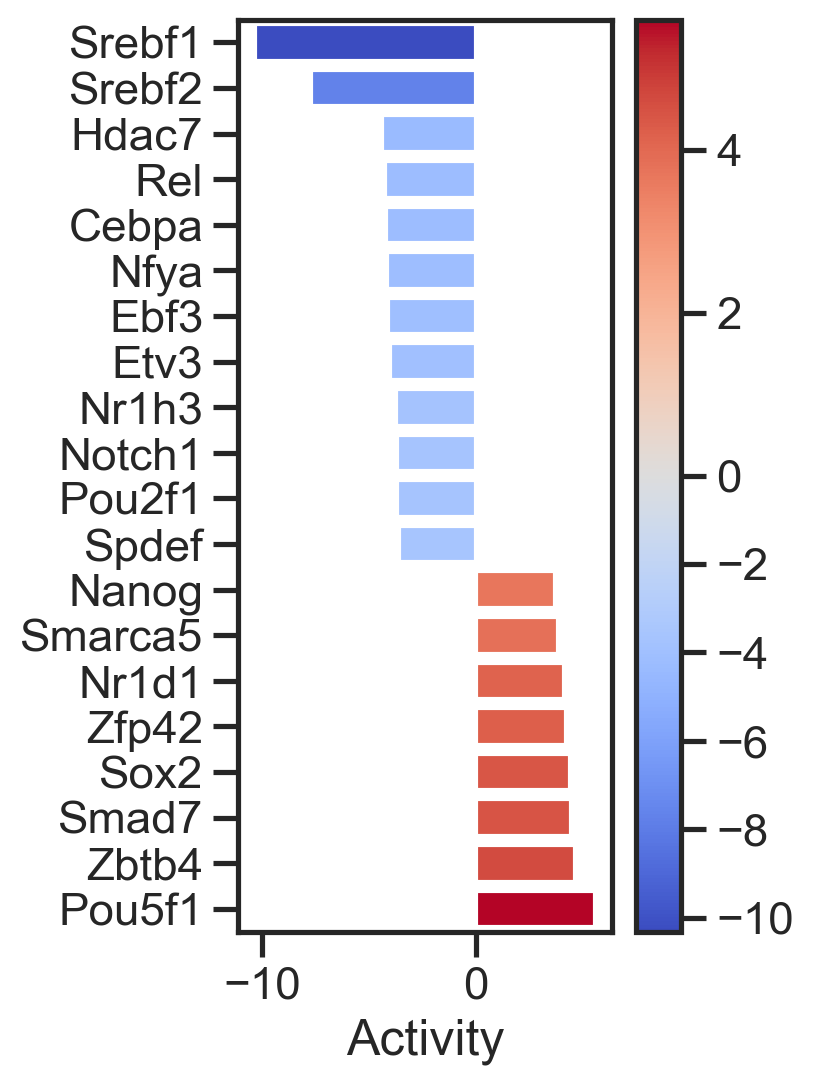

In [205]:
dc.plot_barplot(
    acts=tf_acts,contrast='ESC',
    top=20,vertical=True,figsize=(3, 6))



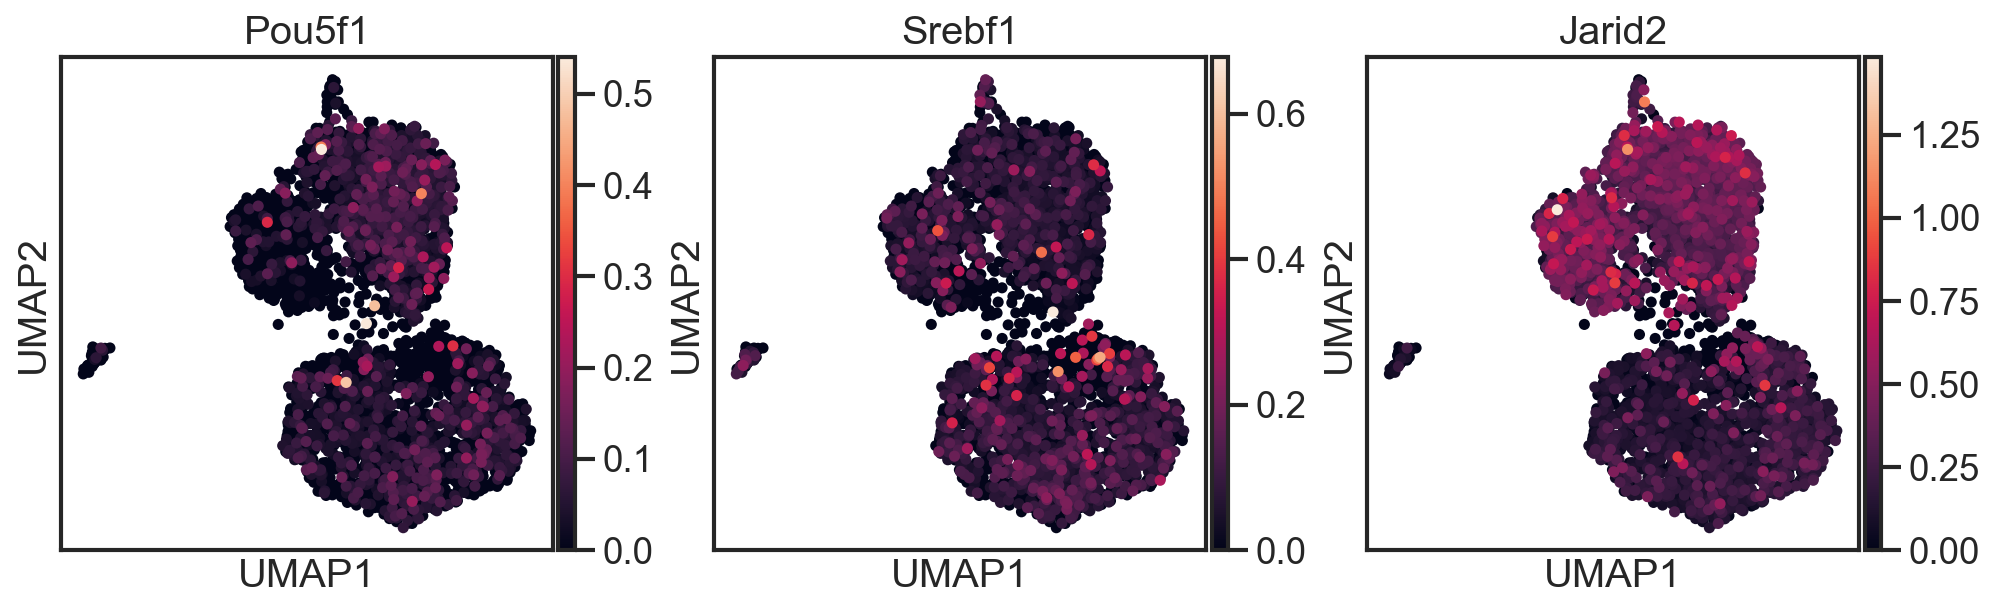

/Users/m.blotenburg/miniconda3/envs/multiconda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/m.blotenburg/miniconda3/envs/multiconda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


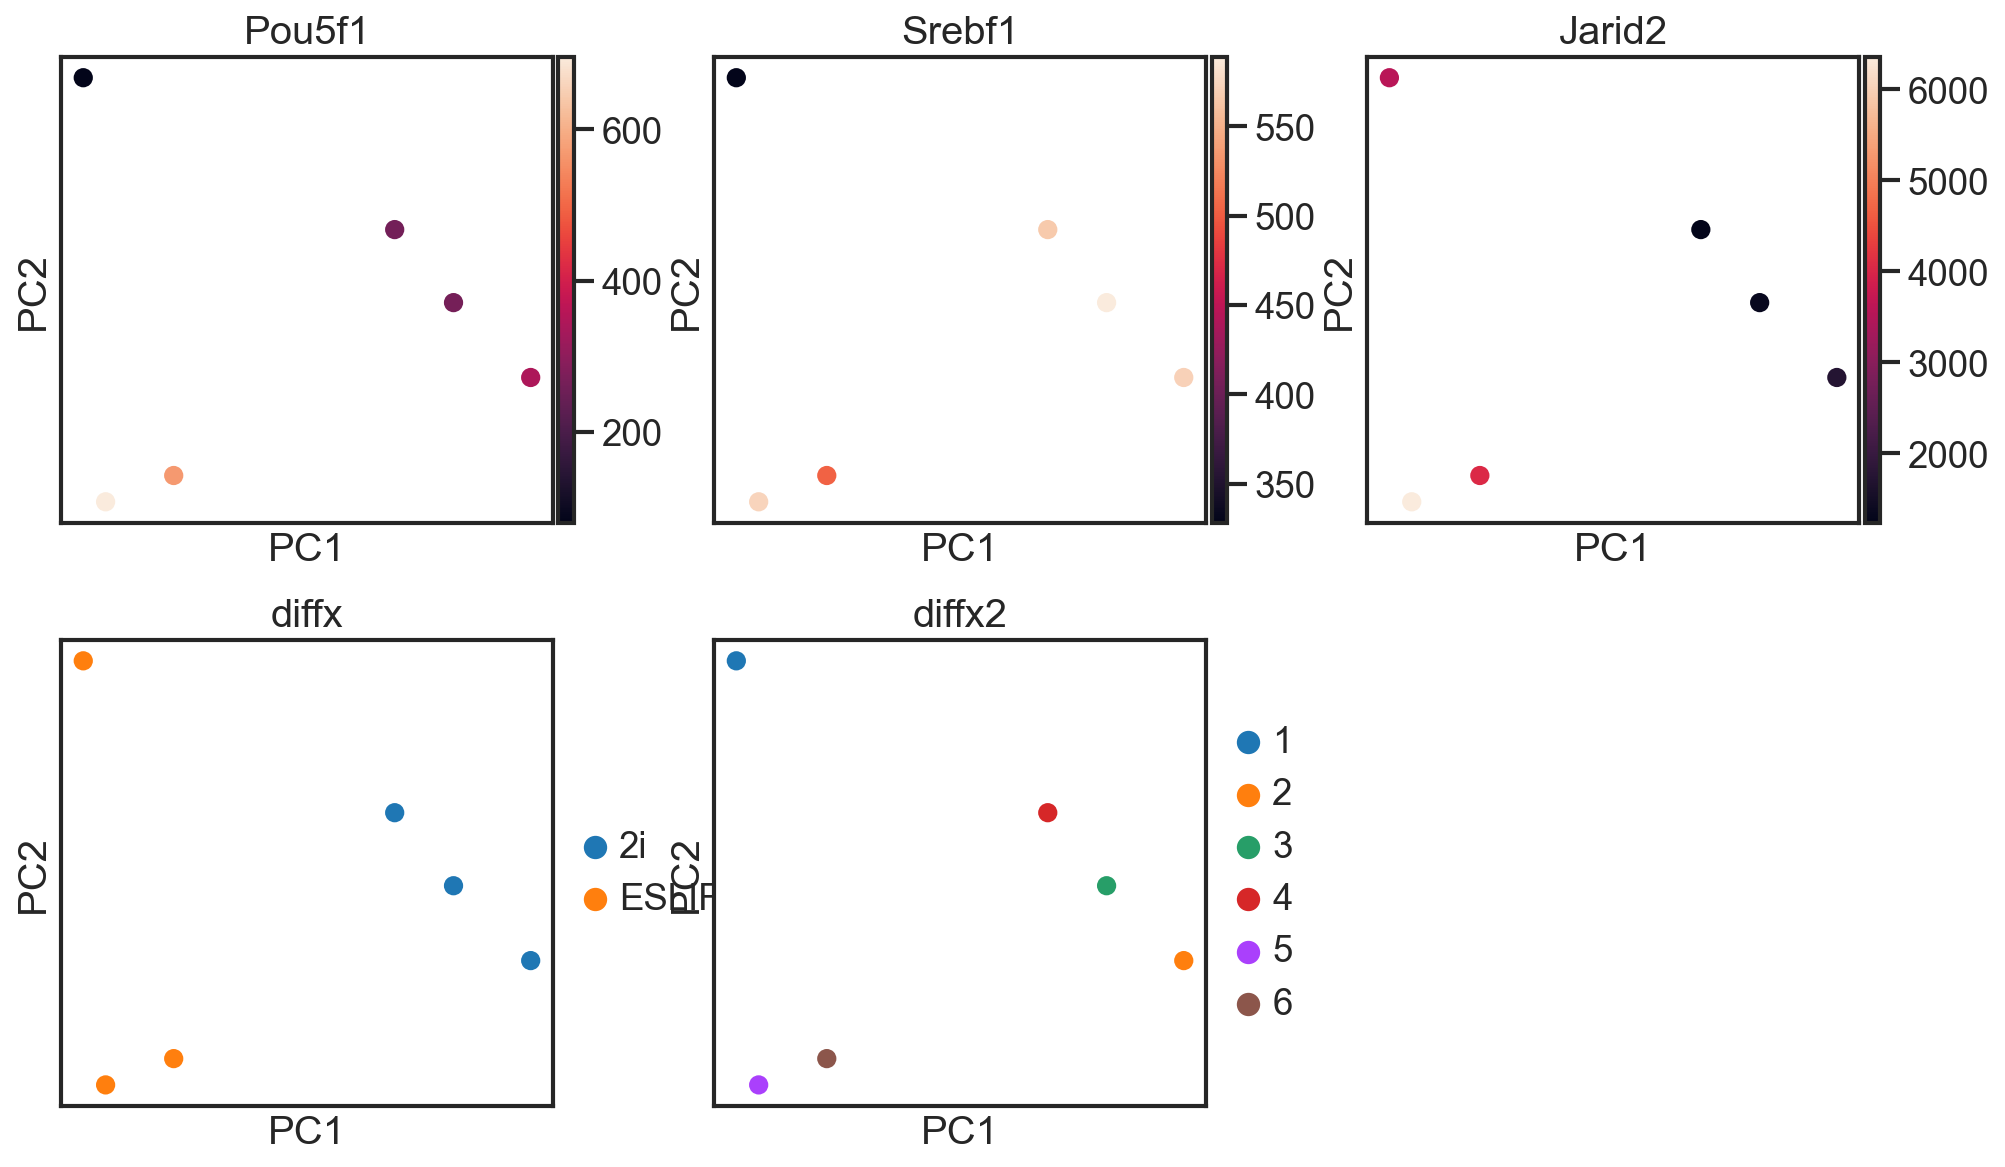

In [270]:
sc.pl.umap(adata,color = ['Pou5f1', 'Srebf1','Jarid2'],size=100)
sc.pl.pca(pdata, color=['Pou5f1', 'Srebf1','Jarid2','diffx','diffx2'], ncols=3, size=300)


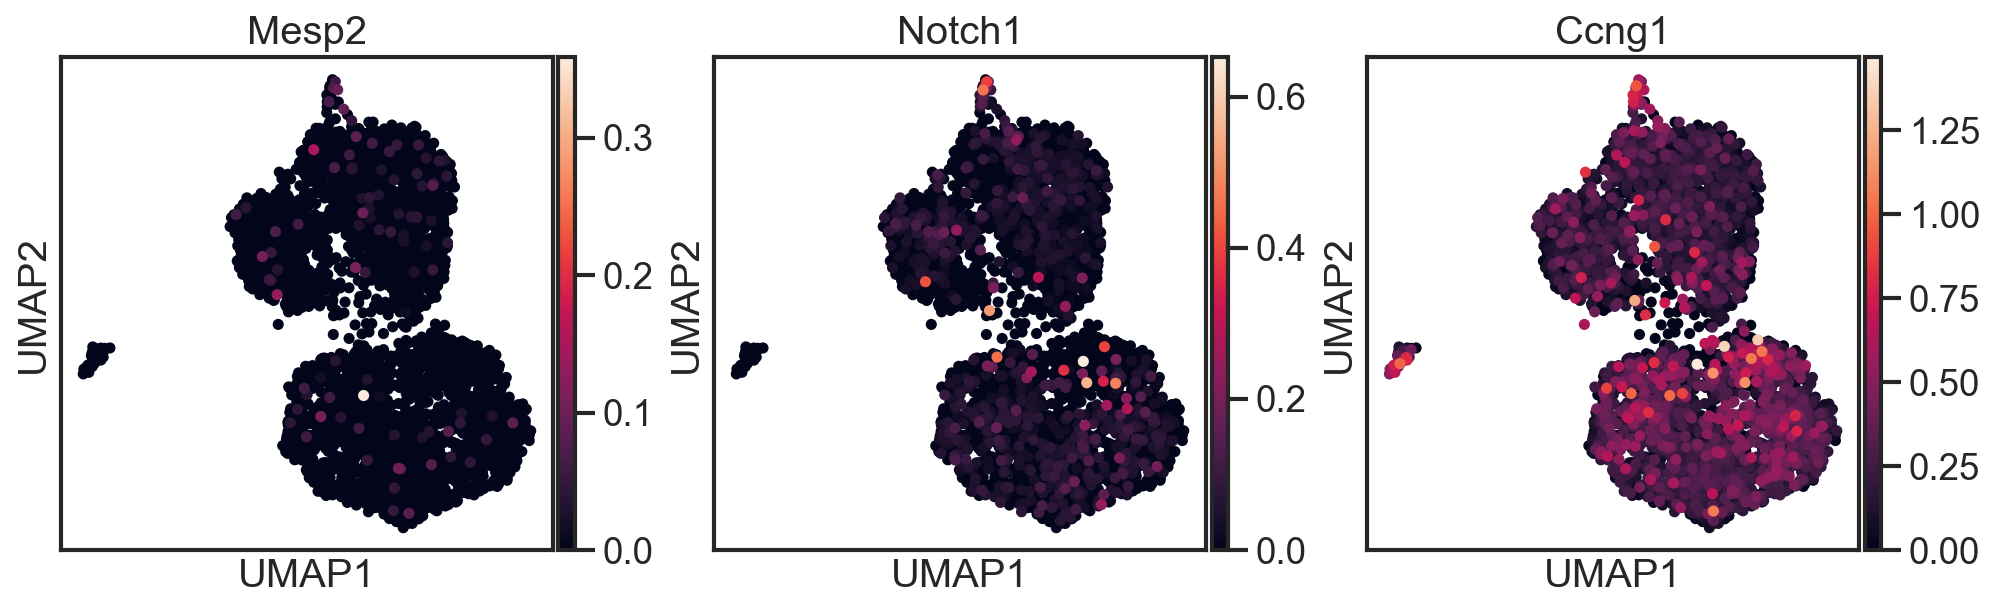

In [460]:
sc.pl.umap(adata, color = ['Mesp2', 'Notch1','Ccng1'], size = 100)

In [266]:
pdata.obs['diffx2'] = pdata.obs['diffx2'].astype('category')

PROGENy is a comprehensive resource containing a curated collection of pathways and their target genes, with weights for each interaction.\
Here is a brief description of each pathway:

- Androgen: involved in the growth and development of the male reproductive organs.
- EGFR: regulates growth, survival, migration, apoptosis, proliferation, and differentiation in mammalian cells
- Estrogen: promotes the growth and development of the female reproductive organs.
- Hypoxia: promotes angiogenesis and metabolic reprogramming when O2 levels are low.
- JAK-STAT: involved in immunity, cell division, cell death, and tumor formation.
- MAPK: integrates external signals and promotes cell growth and proliferation.
- NFkB: regulates immune response, cytokine production and cell survival.
- p53: regulates cell cycle, apoptosis, DNA repair and tumor suppression.
- PI3K: promotes growth and proliferation.
- TGFb: involved in development, homeostasis, and repair of most tissues.
- TNFa: mediates haematopoiesis, immune surveillance, tumour regression and protection from infection.
- Trail: induces apoptosis.
- VEGF: mediates angiogenesis, vascular permeability, and cell migration.
- WNT: regulates organ morphogenesis during development and tissue repair.

In [206]:
#progeny = dc.get_progeny(organism='human', top=500)
progeny = pd.read_csv('/Users/m.blotenburg/Documents/Projects/TCHIC/data/jupyter_notebooks/2024/fig4/20240306_progenytable.csv',index_col=0)

progeny


source     weight       p_value   target
0     Androgen  11.490631  0.000000e+00  Tmprss2
1     Androgen  10.622551  2.200000e-44   Nkx3-1
2     Androgen  10.472733  4.600000e-44   Mboat2
5     Androgen   7.363805  1.253072e-39  Slc38a4
6     Androgen   6.130646  2.534403e-38    Mtmr9
...        ...        ...           ...      ...
6995       p53  -2.325751  1.522388e-06    Zmym4
6996       p53  -1.628168  1.526045e-06    Cfdp1
6997       p53   2.309503  1.537098e-06   Vps37d
6998       p53  -2.274823  1.547037e-06    Tedc1
6999       p53  -3.205113  1.568159e-06  Ccdc138

[6530 rows x 4 columns]

In [210]:
adata

AnnData object with n_obs × n_vars = 4147 × 24136
    obs: 'n_counts', 'n_genes', 'percent_mito', 'S_score', 'G2M_score', 'phase', 'batch', 'name', 'condition', 'plate', 'leiden', 'Condition', 'diffx', 'diffx2'
    var: 'ensembl', 'chromosome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'ensembl_chrom'
    uns: 'batch_colors', 'condition_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'Condition_colors', 'diffx_colors', 'diffx2_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [211]:
progeny = progeny[~progeny.duplicated(['source', 'target'])]#.sum()

In [212]:
progeny

source     weight       p_value   target
0     Androgen  11.490631  0.000000e+00  Tmprss2
1     Androgen  10.622551  2.200000e-44   Nkx3-1
2     Androgen  10.472733  4.600000e-44   Mboat2
5     Androgen   7.363805  1.253072e-39  Slc38a4
6     Androgen   6.130646  2.534403e-38    Mtmr9
...        ...        ...           ...      ...
6995       p53  -2.325751  1.522388e-06    Zmym4
6996       p53  -1.628168  1.526045e-06    Cfdp1
6997       p53   2.309503  1.537098e-06   Vps37d
6998       p53  -2.274823  1.547037e-06    Tedc1
6999       p53  -3.205113  1.568159e-06  Ccdc138

[6530 rows x 4 columns]

In [213]:
dc.run_mlm(
    mat=adata,
    net=progeny,
    source='source',
    target='target',
    weight='weight',
    verbose=True
)

Running mlm on mat with 4147 samples and 24136 targets for 14 sources.


In [214]:
adata.obsm['mlm_estimate']

Androgen      EGFR  Estrogen   Hypoxia  JAK-STAT      MAPK  \
e1_1.m-ESC_con1    2.104353 -2.217131  0.202157 -0.562182 -1.735889  8.499321   
e1_10.m-ESC_con1   1.132115  1.770174  0.643743  3.389817 -0.626709  6.327189   
e1_101.m-ESC_con1  0.454732 -1.740661  0.776611  5.121143 -0.811721  6.133251   
e1_102.m-ESC_con1  1.971719 -1.224481  1.335617  0.510828 -0.582509  7.243279   
e1_103.m-ESC_con1 -0.278676 -0.589855  1.821988  3.855687 -1.291149  7.311734   
...                     ...       ...       ...       ...       ...       ...   
e12_95.m-ESC_con6  1.747039 -0.432323  0.951144  1.370378 -0.866959  6.812813   
e12_96.m-ESC_con6  2.541840 -1.204435 -0.034533  1.034266 -0.770375  6.025337   
e12_97.m-ESC_con6  1.255640 -1.268193 -0.169602 -1.206940  0.746230  6.677048   
e12_98.m-ESC_con6  0.959332 -1.934343  1.174612 -1.880471 -1.208153  4.687961   
e12_99.m-ESC_con6  1.710442 -0.397347  0.915254 -0.883343 -0.034430  6.241391   

                       NFkB      PI3K      TGFb      TNFa      Trail  \
e1_1.m-ESC_con1   -0.955678 -0.325245  1.312794  0.418520 -10.264644   
e1_10.m-ESC_con1  -1.755053 -0.177624  0.569362  1.169396  -8.743318   
e1_101.m-ESC_con1 -1.355809  1.130461  1.744077  0.900342  -9.405442   
e1_102.m-ESC_con1 -1.243189  1.684516  1.333387  0.485776 -10.403489   
e1_103.m-ESC_con1 -0.792500  1.821434  0.848086  0.604755  -9.657322   
...                     ...       ...       ...       ...        ...   
e12_95.m-ESC_con6 -0.879519  1.951762  1.322083  0.646178 -10.912280   
e12_96.m-ESC_con6 -1.498273 -0.155169  0.266159  1.127395 -10.179045   
e12_97.m-ESC_con6 -1.725848  0.708632  1.548266  0.318182  -7.266834   
e12_98.m-ESC_con6 -1.222370  1.606793  0.934724  0.557784 -10.876354   
e12_99.m-ESC_con6 -1.795528  1.048435  1.681465  0.877456 -10.830633   

                       VEGF       WNT       p53  
e1_1.m-ESC_con1    3.206292 -0.585514 -8.838141  
e1_10.m-ESC_con1   1.611966  0.269874 -3.366170  
e1_101.m-ESC_con1  1.332103 -0.578938 -9.524446  
e1_102.m-ESC_con1  1.155116 -1.083733 -7.174922  
e1_103.m-ESC_con1  0.015151 -1.254040 -5.650029  
...                     ...       ...       ...  
e12_95.m-ESC_con6  2.435355 -0.761055 -6.833231  
e12_96.m-ESC_con6  4.185169 -0.168836 -5.863503  
e12_97.m-ESC_con6  2.587549  0.121069 -3.219582  
e12_98.m-ESC_con6  2.096111 -0.508910 -4.746164  
e12_99.m-ESC_con6  2.959165 -0.865380 -5.798455  

[4147 rows x 14 columns]

In [215]:
adata.obsm['progeny_mlm_estimate'] = adata.obsm['mlm_estimate'].copy()
adata.obsm['progeny_mlm_pvals'] = adata.obsm['mlm_pvals'].copy()
adata

AnnData object with n_obs × n_vars = 4147 × 24136
    obs: 'n_counts', 'n_genes', 'percent_mito', 'S_score', 'G2M_score', 'phase', 'batch', 'name', 'condition', 'plate', 'leiden', 'Condition', 'diffx', 'diffx2'
    var: 'ensembl', 'chromosome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'ensembl_chrom'
    uns: 'batch_colors', 'condition_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'Condition_colors', 'diffx_colors', 'diffx2_colors'
    obsm: 'X_pca', 'X_umap', 'mlm_estimate', 'mlm_pvals', 'progeny_mlm_estimate', 'progeny_mlm_pvals'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [216]:
acts = dc.get_acts(adata, obsm_key='mlm_estimate')
acts

AnnData object with n_obs × n_vars = 4147 × 14
    obs: 'n_counts', 'n_genes', 'percent_mito', 'S_score', 'G2M_score', 'phase', 'batch', 'name', 'condition', 'plate', 'leiden', 'Condition', 'diffx', 'diffx2'
    uns: 'batch_colors', 'condition_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'Condition_colors', 'diffx_colors', 'diffx2_colors'
    obsm: 'X_pca', 'X_umap', 'mlm_estimate', 'mlm_pvals', 'progeny_mlm_estimate', 'progeny_mlm_pvals'

/Users/m.blotenburg/miniconda3/envs/multiconda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


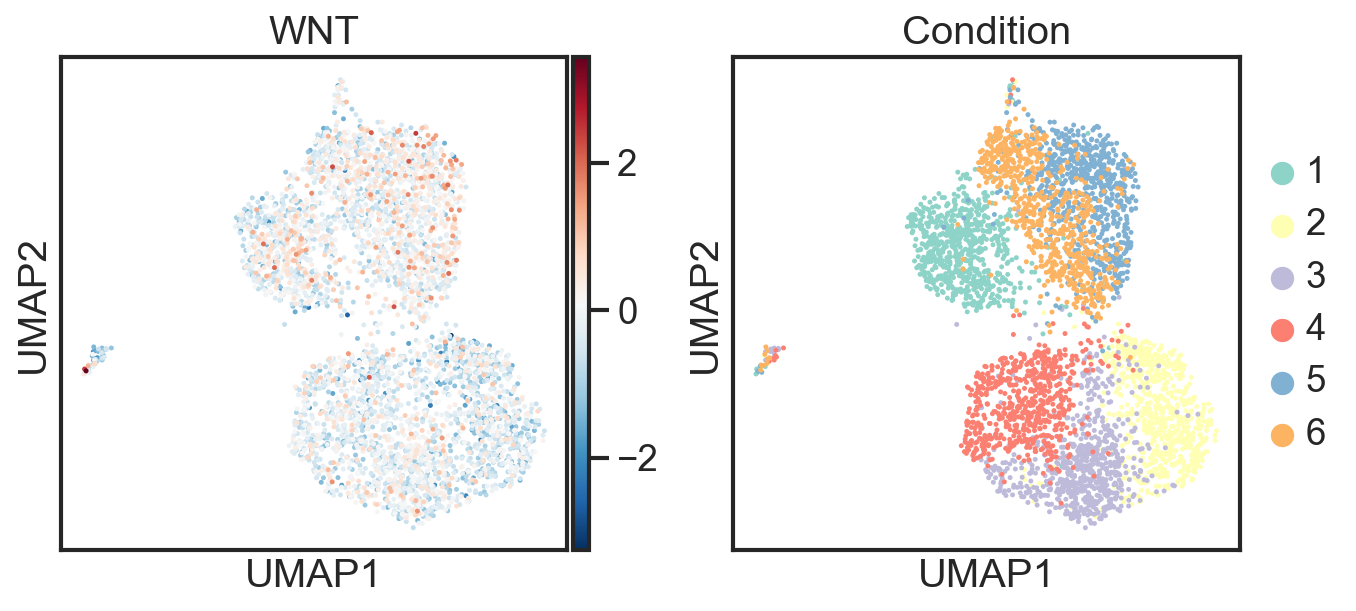

In [218]:
sc.pl.umap(acts, color=['WNT', 'Condition'], cmap='RdBu_r', size = 20)

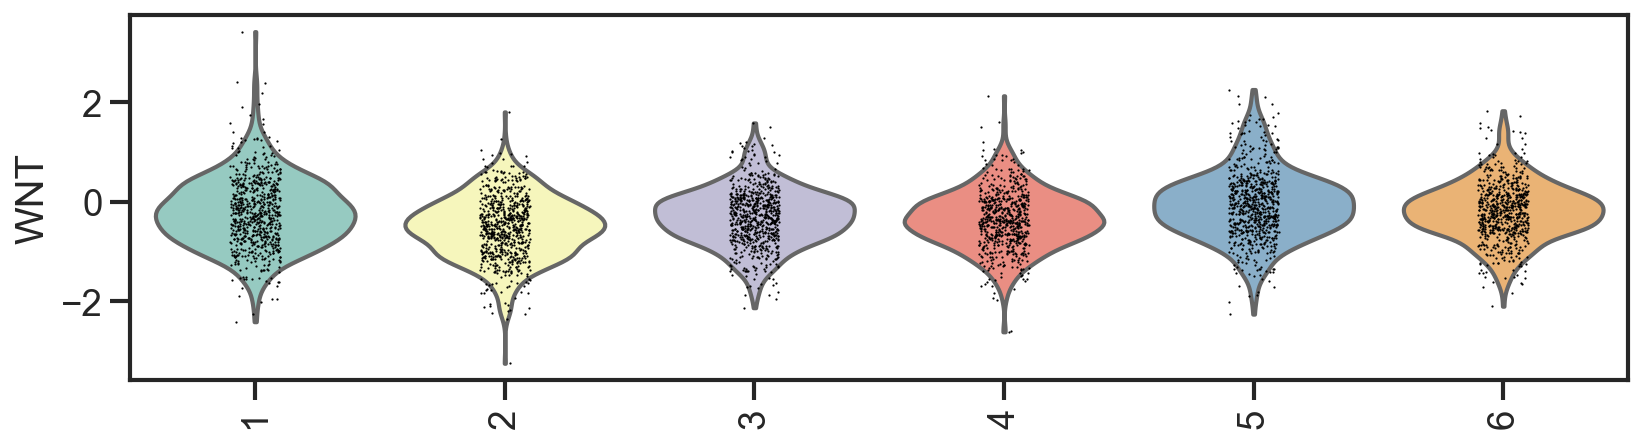

In [221]:
fig,ax=plt.subplots(figsize=(12,3))
sc.pl.violin(acts, keys=['WNT'], groupby='Condition', rotation=90,ax=ax, #cols = adata.uns['Condition_colors'], 
             order = adata.obs['Condition'].cat.categories)

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_Condition']`


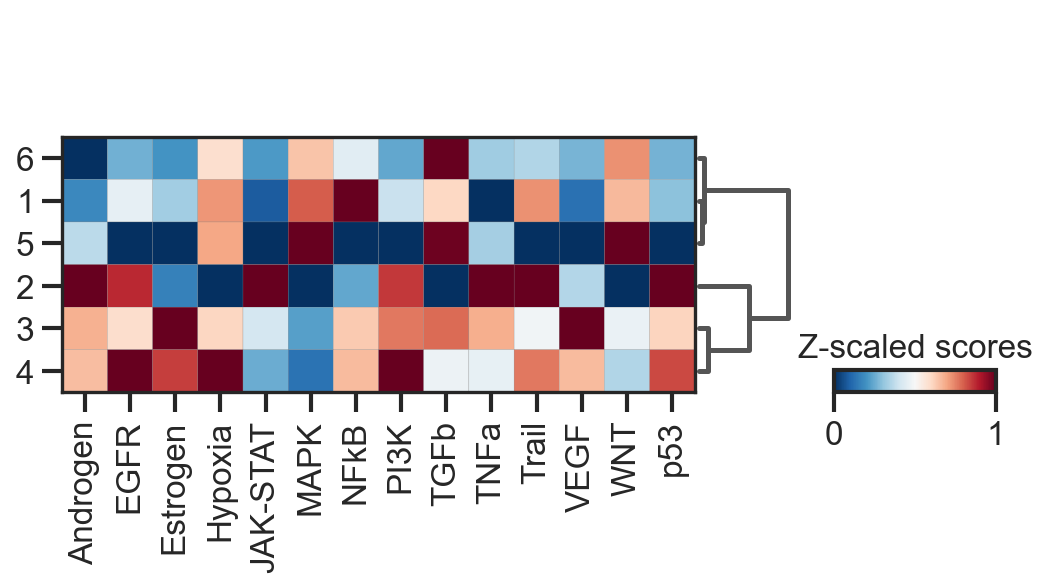

In [222]:
sc.pl.matrixplot(acts, var_names=acts.var_names, groupby='Condition', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

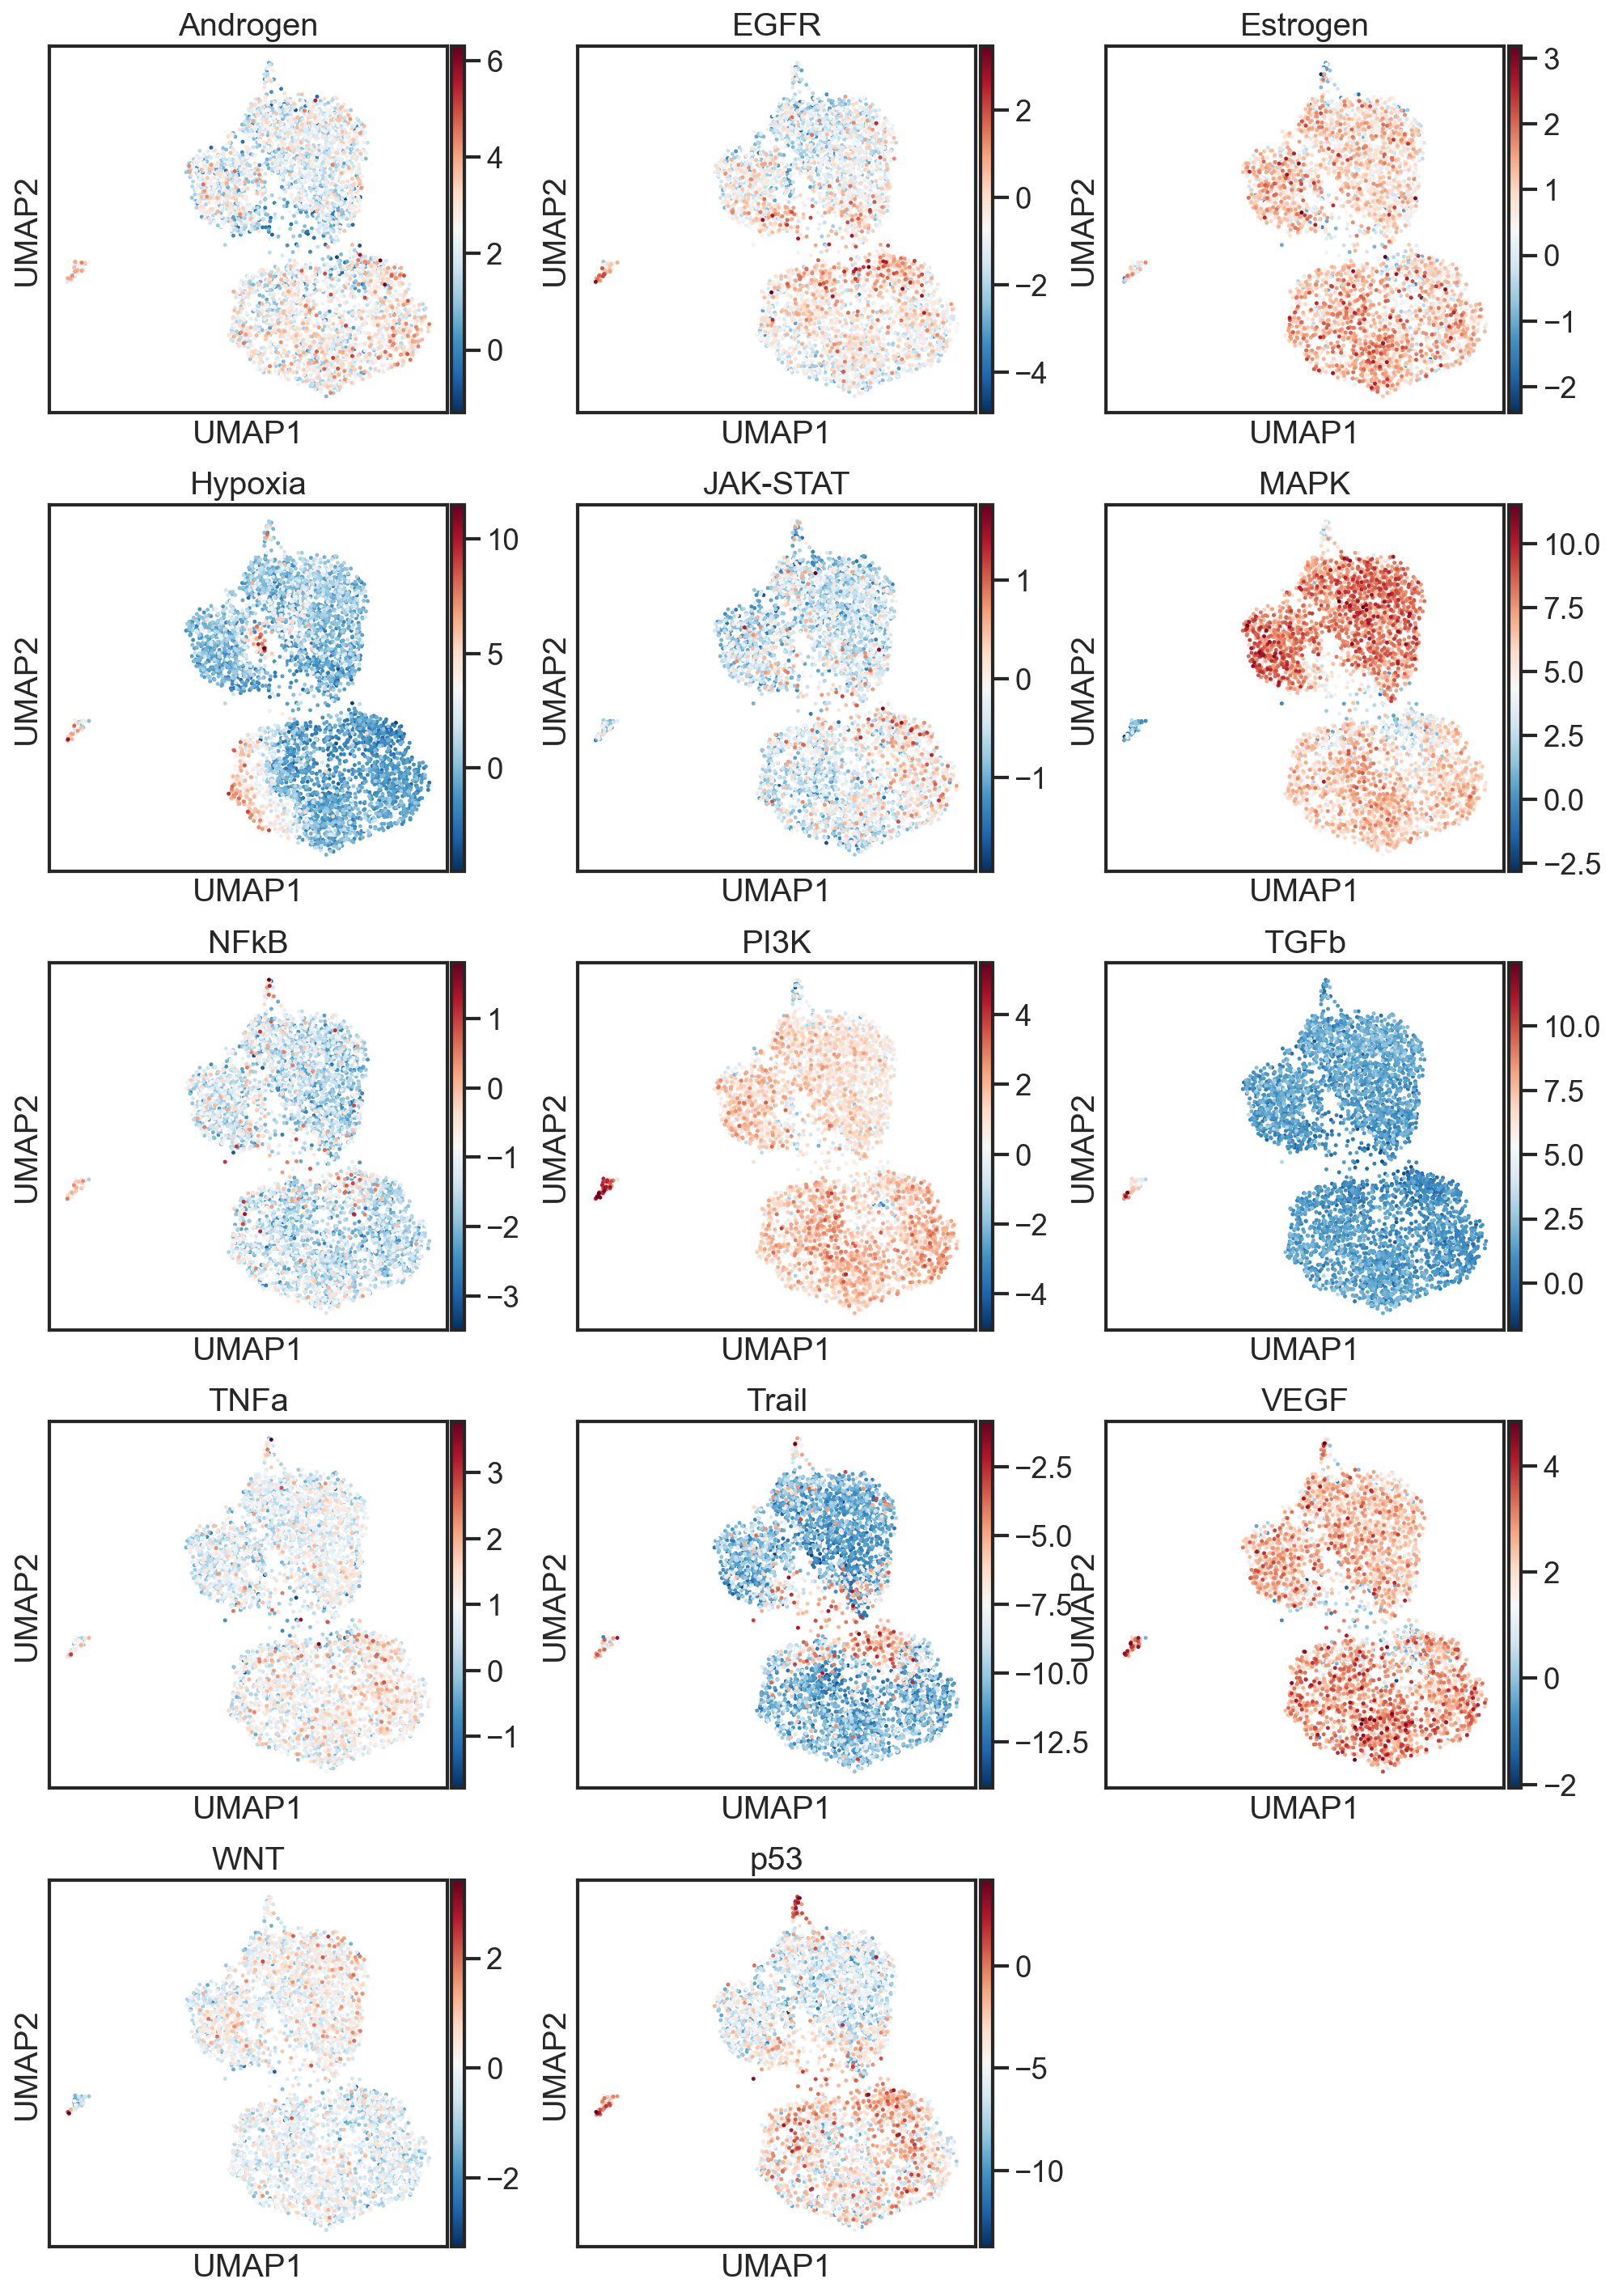

In [223]:
sc.pl.umap(acts, color=acts.var.index, cmap='RdBu_r', size = 20, ncols = 3)